# Background:

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes. 

The CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 


# Objective:

Your job is to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then you need to suggest the countries which the CEO needs to focus on the most.

# 1. Data Inspection & Analysis

In [1]:
#import all the libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# To perform KMeans clustering & Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# Supress Warnings
#Enable autocomplete in Jupyter Notebook.
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings('ignore')
import os

## Set the max display columns to None so that pandas doesn't sandwich the output 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)

In [2]:
### Read the input file provided: Country-data.csv 
### & examine that the values are read correctly
countriesDataset = pd.read_csv('./Country-data.csv')
countriesDataset.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


We will now perform some data analysis on the provided data to better understand its structure, we will also check all the data types and columns to see if we need to convert any columns to correct types for analysis. 

In [3]:
countriesDataset.shape

(167, 10)

In [4]:
countriesDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
countriesDataset.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [6]:
### Let us create a function to generate a list of null values in different dataframes
def generateNullValuesPercentageTable(dataframe):
    totalNullValues = dataframe.isnull().sum().sort_values(ascending=False)
    percentageOfNullValues = round((dataframe.isnull().sum()*100/len(dataframe)).sort_values(ascending=False),2)
    columnNamesWithPrcntgOfNullValues = pd.concat([totalNullValues, percentageOfNullValues], axis=1, keys=['Total Null Values', 'Percentage of Null Values'])
    return columnNamesWithPrcntgOfNullValues

generateNullValuesPercentageTable(countriesDataset)

,Total Null Values,Percentage of Null Values
gdpp,0,0.0
total_fer,0,0.0
life_expec,0,0.0
inflation,0,0.0
income,0,0.0
imports,0,0.0
health,0,0.0
exports,0,0.0
child_mort,0,0.0
country,0,0.0


In [7]:
### Checking for duplicate values across all the rows in the columns

countriesDataset[countriesDataset.duplicated(keep=False)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


### Observations:

We can infer from the analysis above:

- The dataset shape is: 167x10
- There are no null values in any of the columns, therefore this is a complete dataset
- There are no duplicated values in the dataset, so we dont have to work on removing those across columns.

# 2. Data Preperation & EDA

Data preparation & EDA will be carried out through the following:

- Convert the columns 'export', 'health' & 'import' to % of gdpp so that the data is consistent and makes sense
- Outlier analysis using percentiles 0.1, 0.25, 0.5, 0.75, 0.90, 0.95 & 0.99
- Outlier analysis using boxplots
- Correlation understanding between various features using heatmaps
- Data visualization using scatter plots 
- Data scalling


In [8]:
### Converting 3 columns 'export', 'health' & 'import'  to % of gdpp
countriesDataset.exports = (countriesDataset.exports*countriesDataset.gdpp)/100
countriesDataset.health = (countriesDataset.health*countriesDataset.gdpp)/100
countriesDataset.imports = (countriesDataset.imports*countriesDataset.gdpp)/100

## View the revised dataset
countriesDataset.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [9]:
### We will set the non-numerical column 'country' as the index
countriesDataset.set_index('country', inplace=True)
countriesDataset.head()
print(countriesDataset.shape)

(167, 9)


#### Note: 
The shape of our dataset has changed because we have now indexed our data according to the countries and dropped the initial index column. We have done this because country is a non-numerical column.

In [10]:
### Outlier analysis using Outlier analysis using percentiles 0.25, 0.5, 0.75, 0.90, 0.95 & 0.99

countriesDataset.describe(percentiles=[ 0.01, 0.25, 0.5, 0.75, 0.90, 0.95 ,0.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
1%,2.800000,22.243716,17.009362,104.909640,742.240000,-2.348800,47.160000,1.243200,331.620000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000


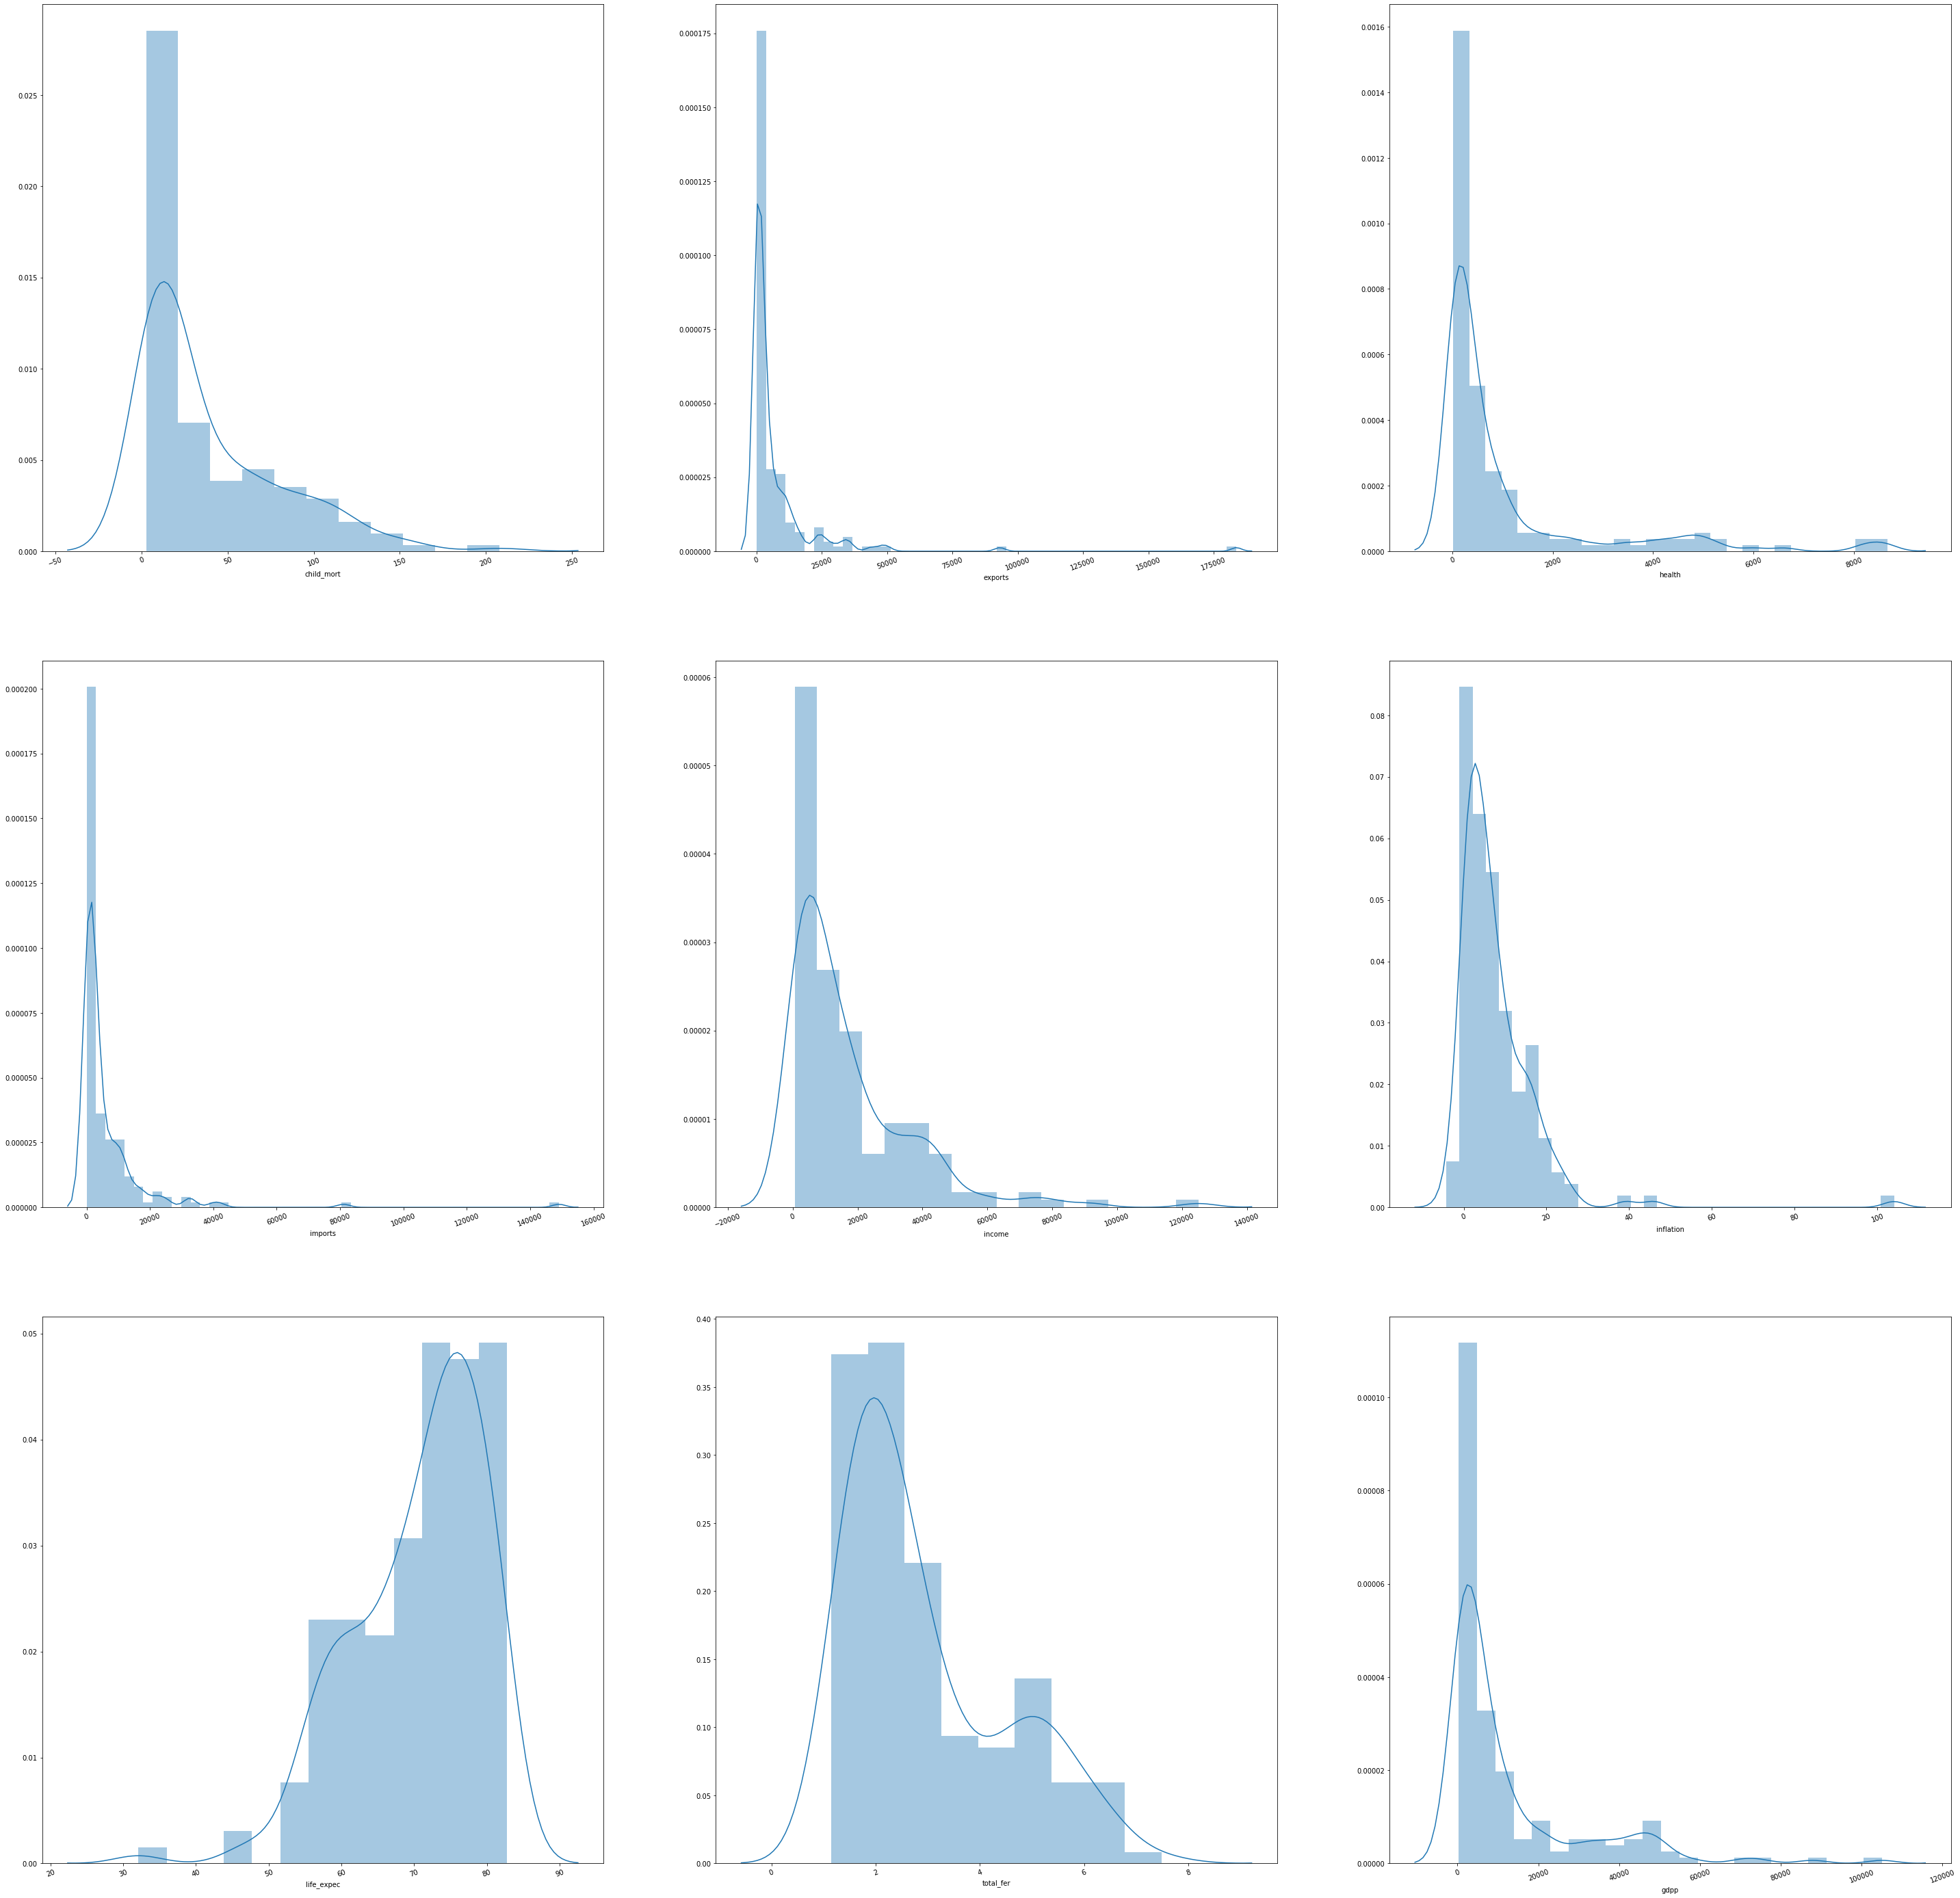

In [11]:
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
plt.figure(figsize=(50,50))
for i in enumerate(features): 
    ax = plt.subplot(3,3, i[0]+1)
    sns.distplot(countriesDataset[i[1]])
    plt.xticks(rotation = 20)

<Figure size 3600x10800 with 0 Axes>

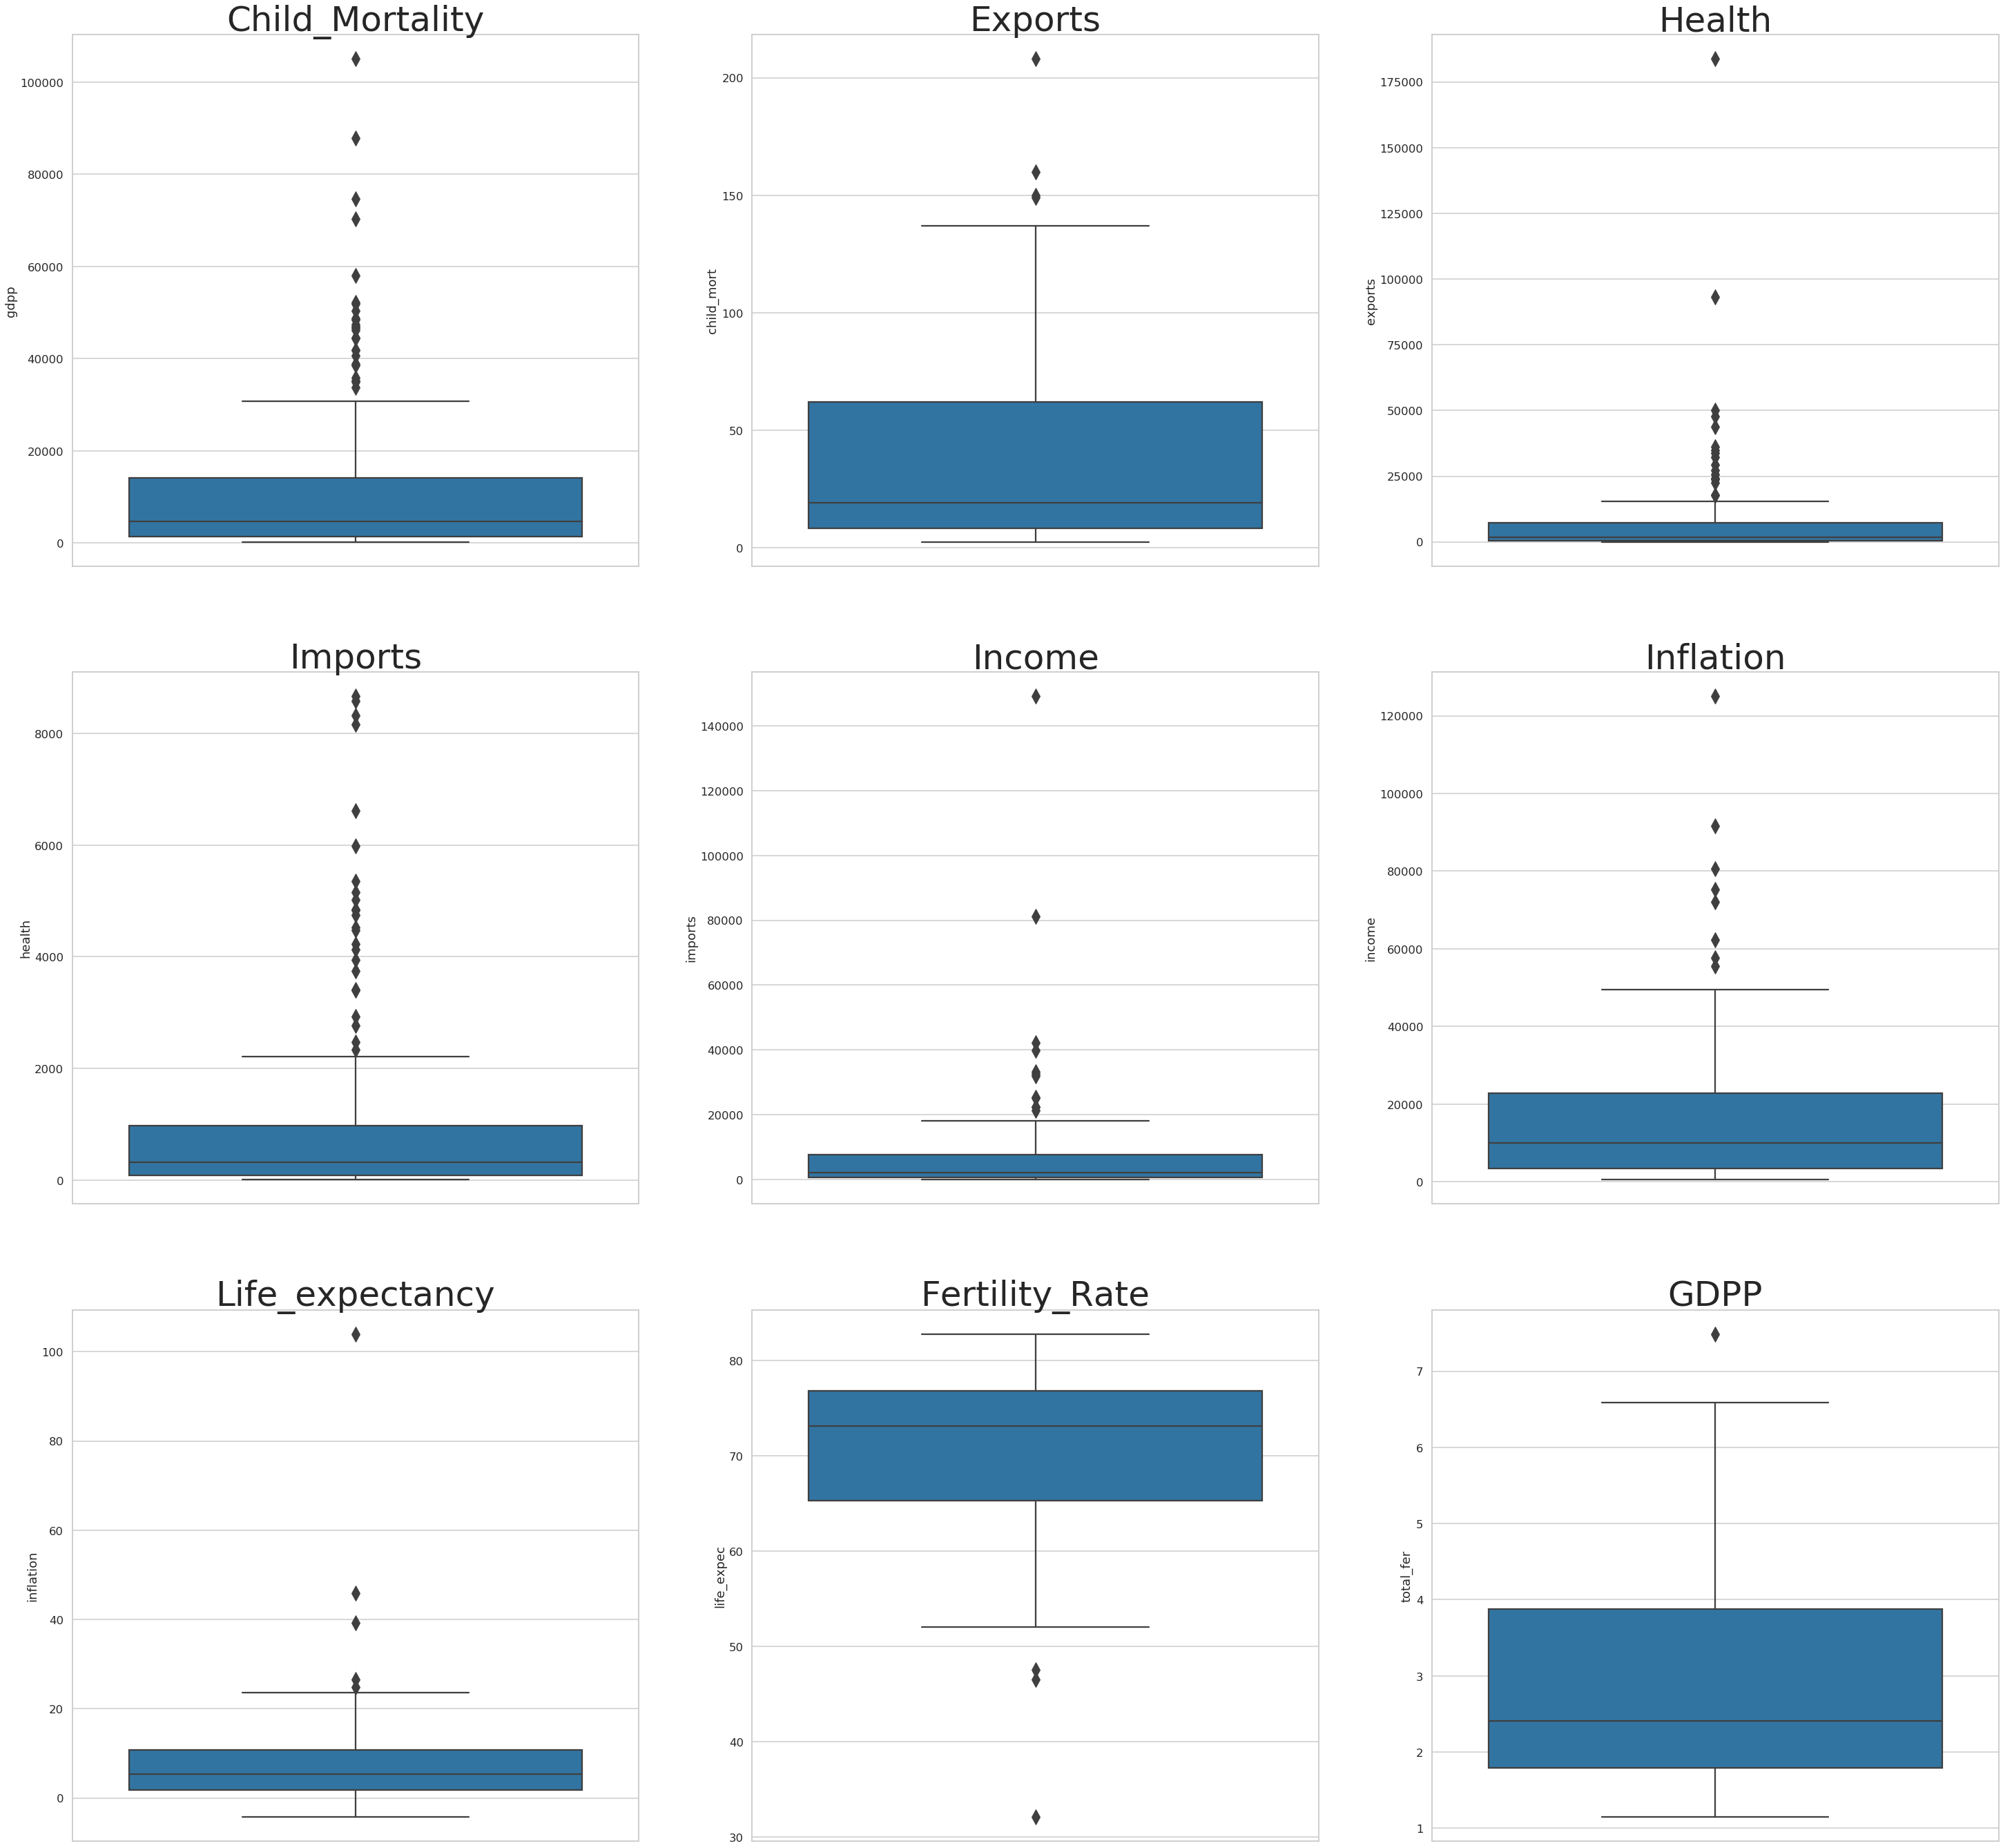

In [12]:
### Performing outlier analysis using boxplots

plt.figure(figsize=(50,150))
plt.tight_layout()
sns.set_style('whitegrid')
sns.set_context('talk')

# Title names for the columns in the dataset

columnNames={0:'Child_Mortality',1:'Exports',2:'Health',3:'Imports',4:'Income',5:'Inflation',
     6:'Life_expectancy',7:'Fertility_Rate',8:'GDPP'}

# Visualising the outliers with boxplot for all the variables 
plt.figure(figsize = (50,150))

for i in range(9):
    plt.subplot(9,3,i+1)
    plt.title(columnNames[i],fontsize=50)
    sns.boxplot(x=countriesDataset.columns[i-1],data=countriesDataset,orient='v',fliersize=15)

<Figure size 1800x1800 with 0 Axes>

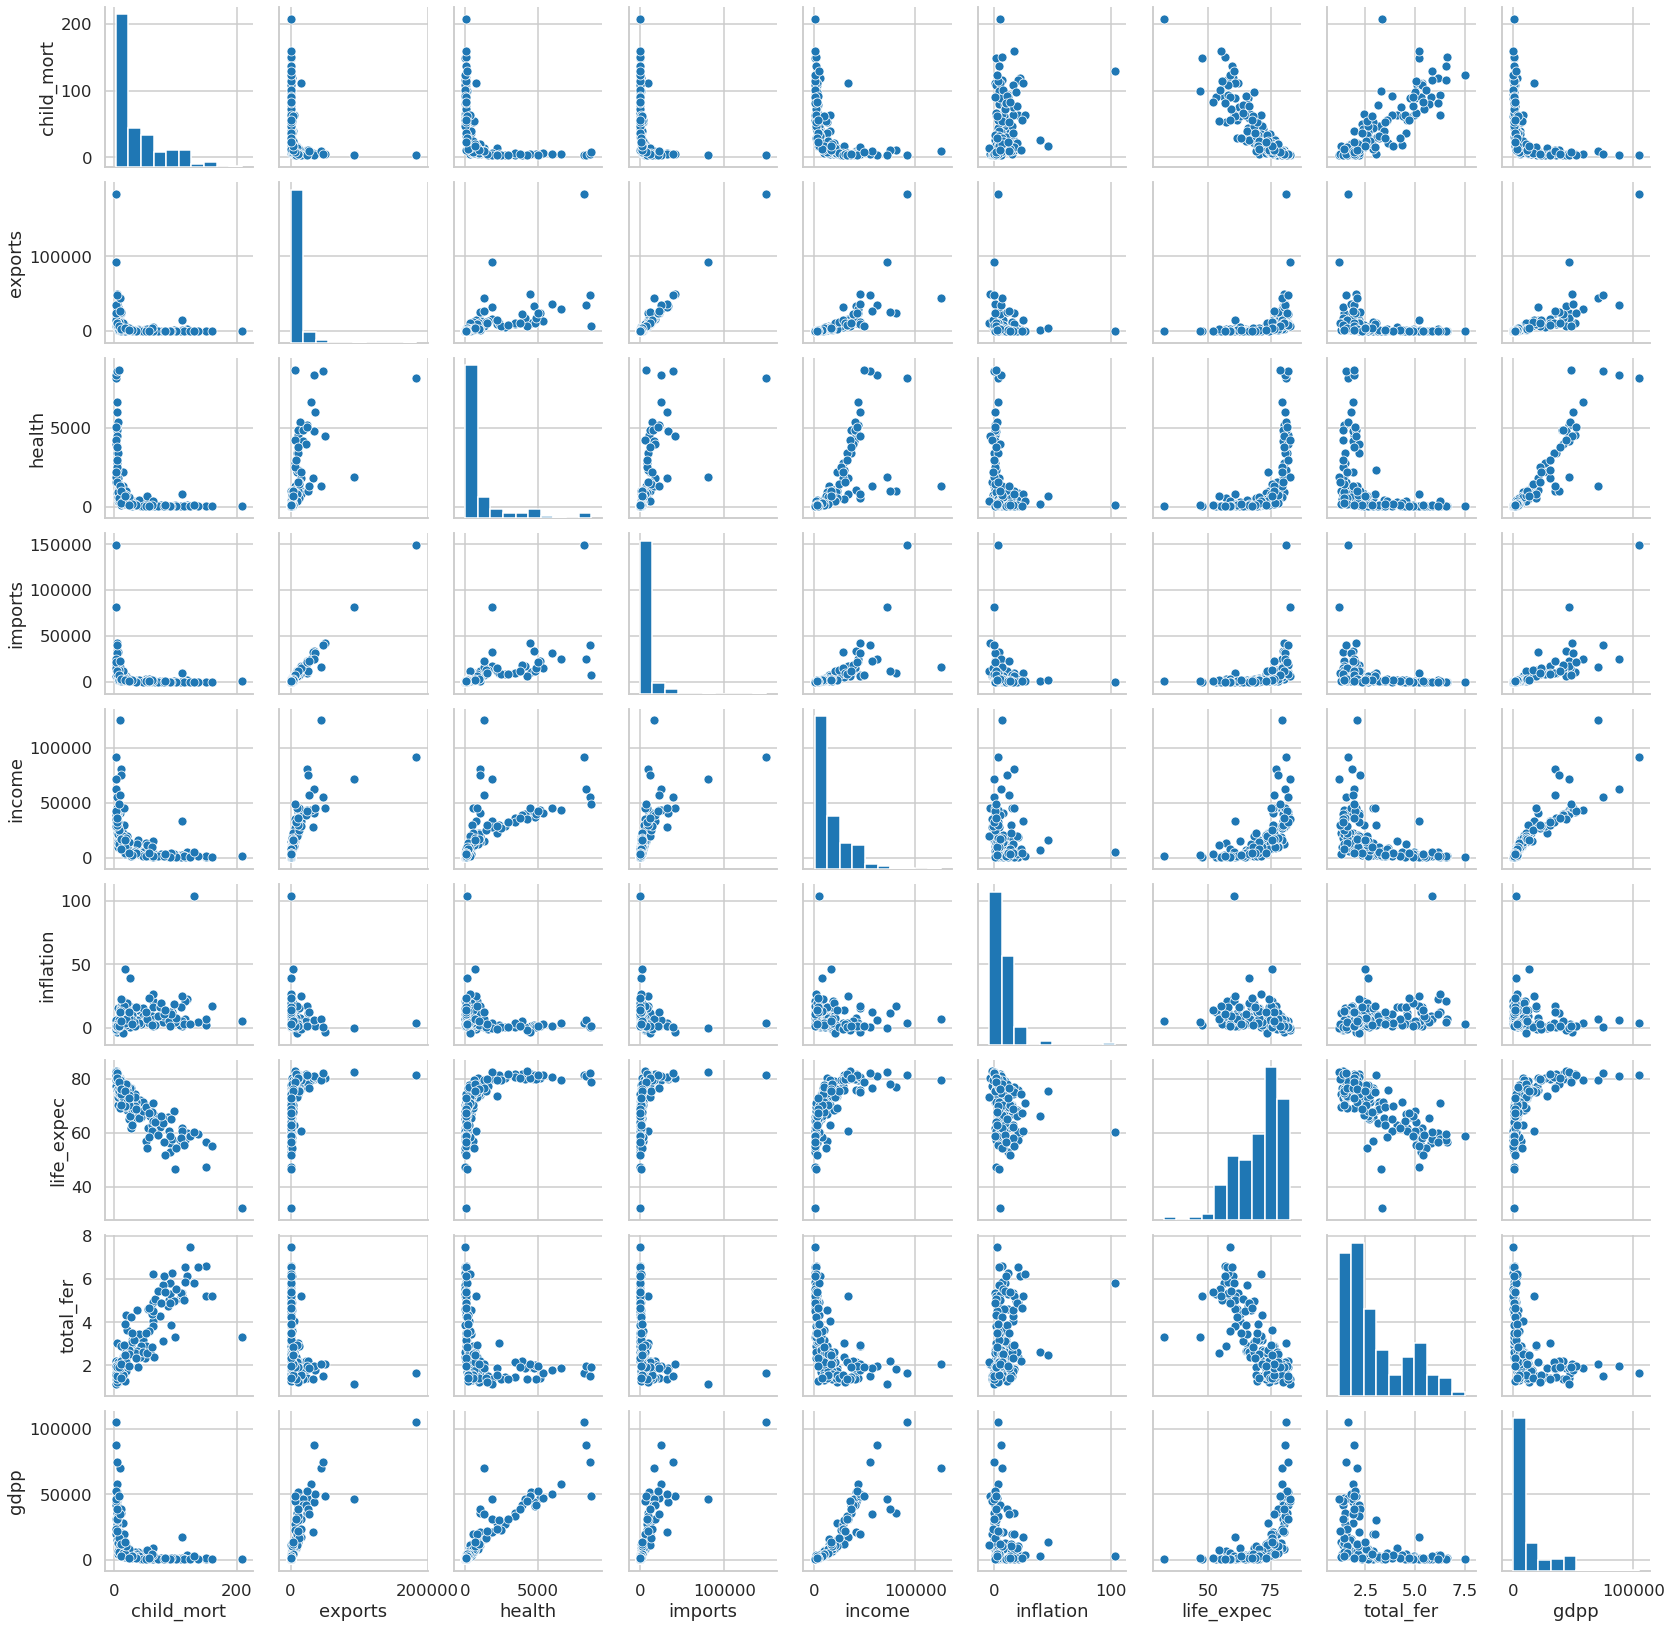

In [13]:
### Let us also plot a pairplot for the same before removing outliers
plt.figure(figsize = (25,25))
sns.pairplot(countriesDataset)
plt.show()

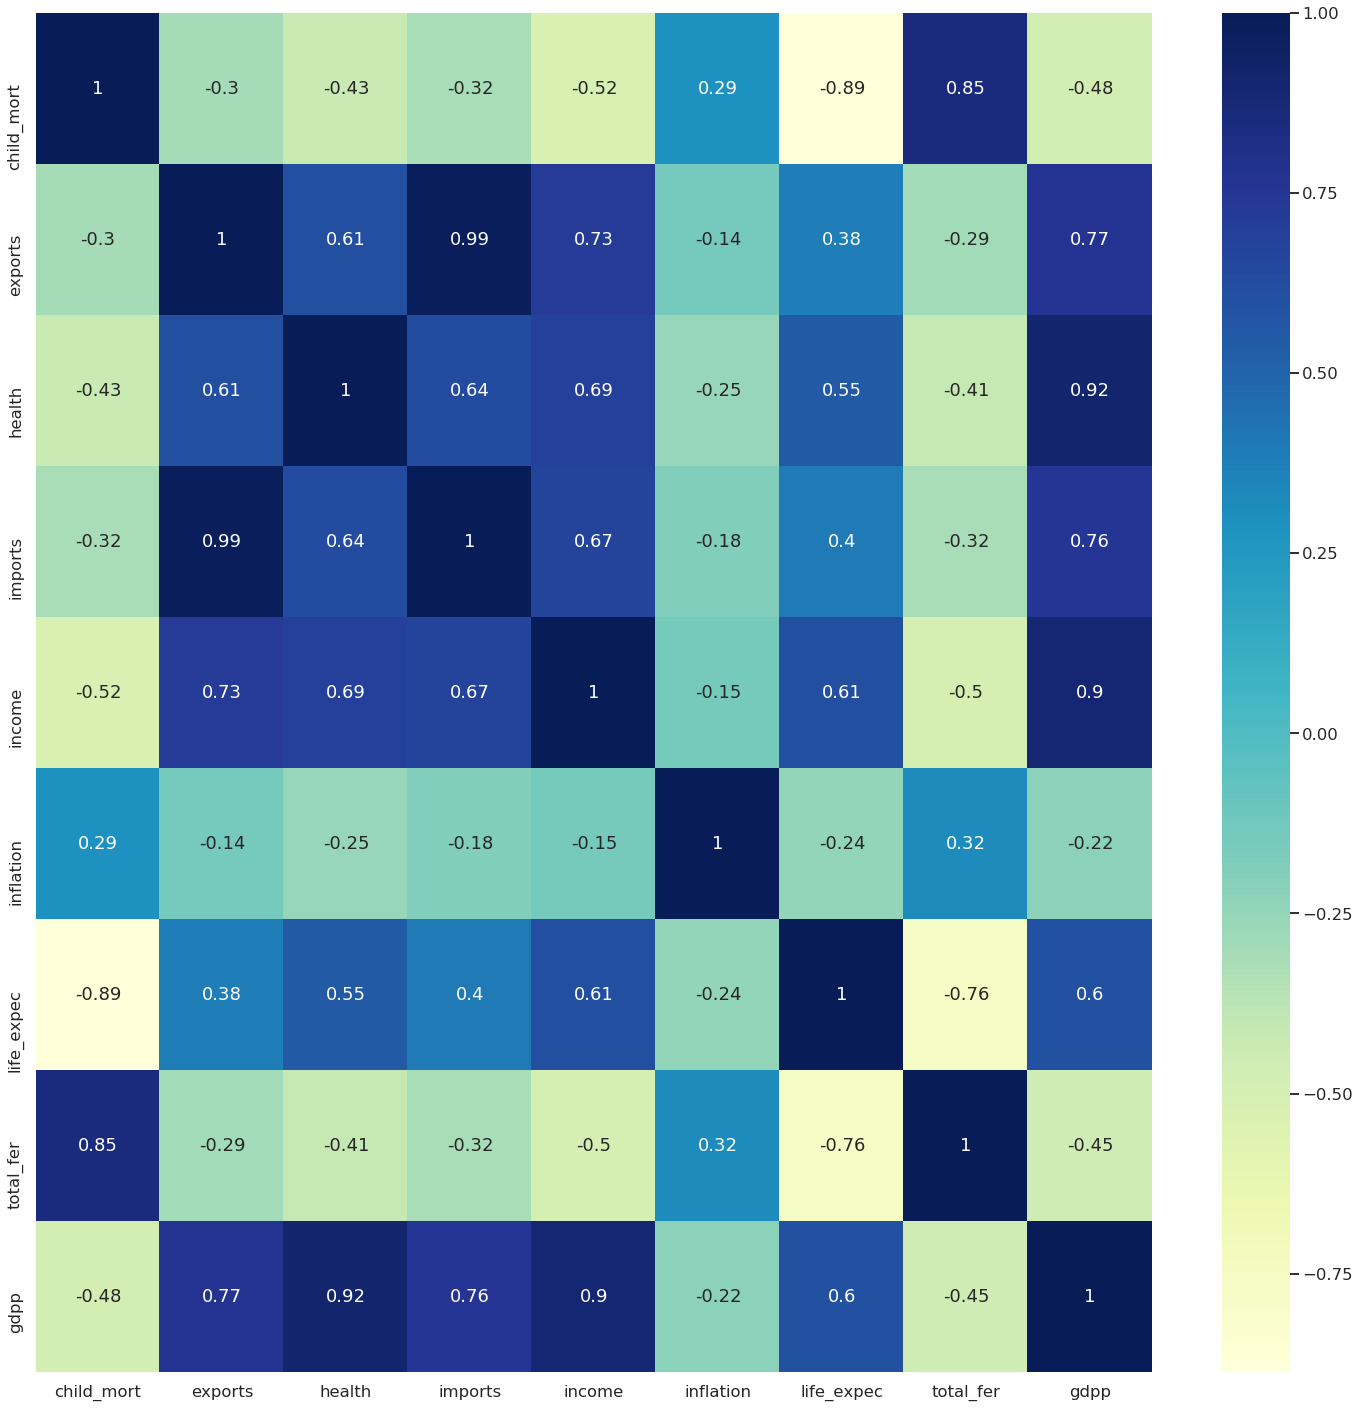

In [14]:
### Let us plot a heatmap to understand the correlation 
### between the data before removing the outliers
plt.figure(figsize = (25,25))  
sns.heatmap(countriesDataset.corr(),annot = True,cmap="YlGnBu")

### Observation:

From the above description & various plots we can see that there are outliers in all the columns. However given our objective to provide aid to countries in absolutely dire need of aid, we will have to perform some more indepth analysis on a few columns before we can treat their outliers.

Based on the above observations we shall perform outlier analysis on all the columns. Following the outlier analysis we will cap the outlier values above 99% and below 1%. 

We will cap these instead of removing them because we might lose essential countries data that might delete countries that are in dire need. 

We will perform this on a separate copy of the dataset so as to keep the original dataset safe.

In [15]:
# removing quartiles for the respective columns.
#create new dataset for removing outliers
countriesDatasetWithoutOutliers = countriesDataset
cols= countriesDataset.columns
def capOutlier(df):
    
    for col in df.columns:
        percentiles = df[col].quantile([0.01,0.99]).values
        df[col][df[col] <= percentiles[0]] = percentiles[0]
        df[col][df[col] >= percentiles[1]] = percentiles[1]
    return df

for i in cols:
    countriesDatasetWithoutOutliers=capOutlier(countriesDatasetWithoutOutliers)
    
    
countriesDatasetWithoutOutliers.describe()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,37.864079,6363.144114,1053.208779,5715.328978,16813.672695,7.375429,70.647305,2.942814,12703.746120
std,38.907166,10597.998751,1786.541047,8664.300847,17788.829390,7.647024,8.540013,1.497106,17229.722432
min,2.800000,23.087649,17.750668,112.304679,763.996114,-1.900080,47.499939,1.249999,333.999575
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,150.000607,50163.613199,8323.455517,42127.865443,80600.673959,39.200407,82.200030,6.550002,74600.801464


In [16]:
### check the shape to ensure that the data isnt lost.
countriesDatasetWithoutOutliers.shape

(167, 9)

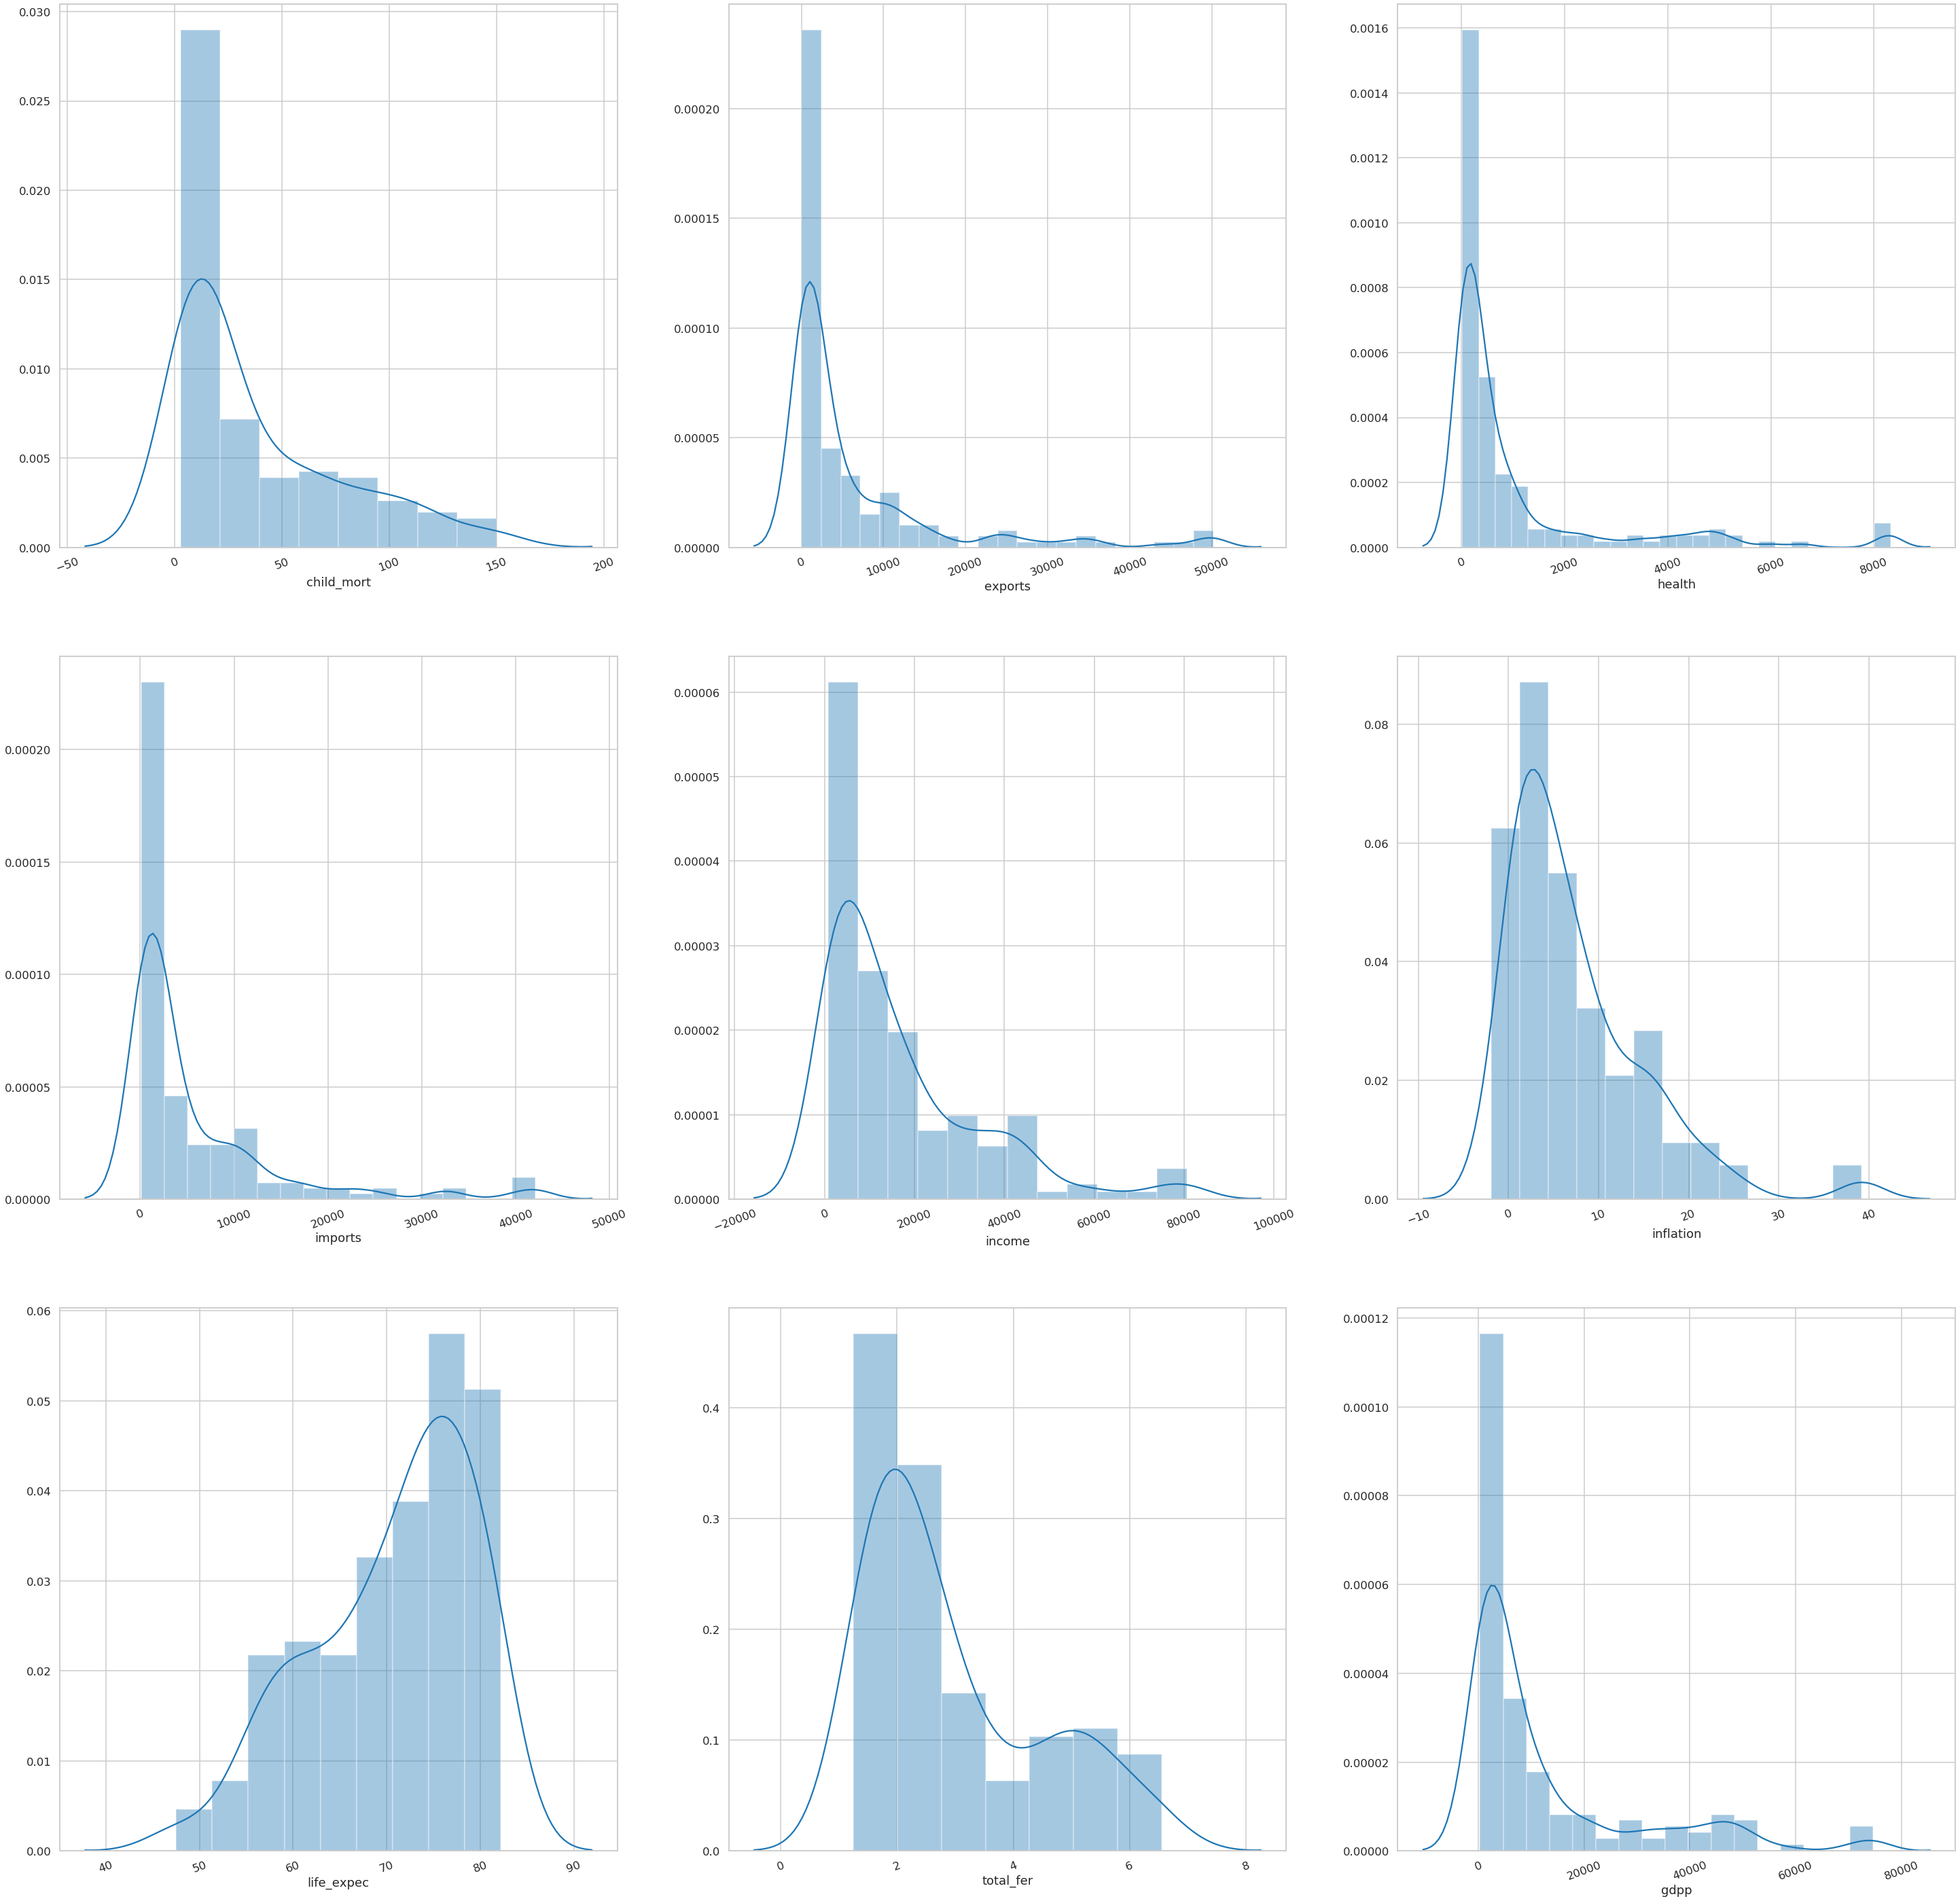

In [17]:
features = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
plt.figure(figsize=(50,50))
for i in enumerate(features): 
    ax = plt.subplot(3,3, i[0]+1)
    sns.distplot(countriesDatasetWithoutOutliers[i[1]])
    plt.xticks(rotation = 20)

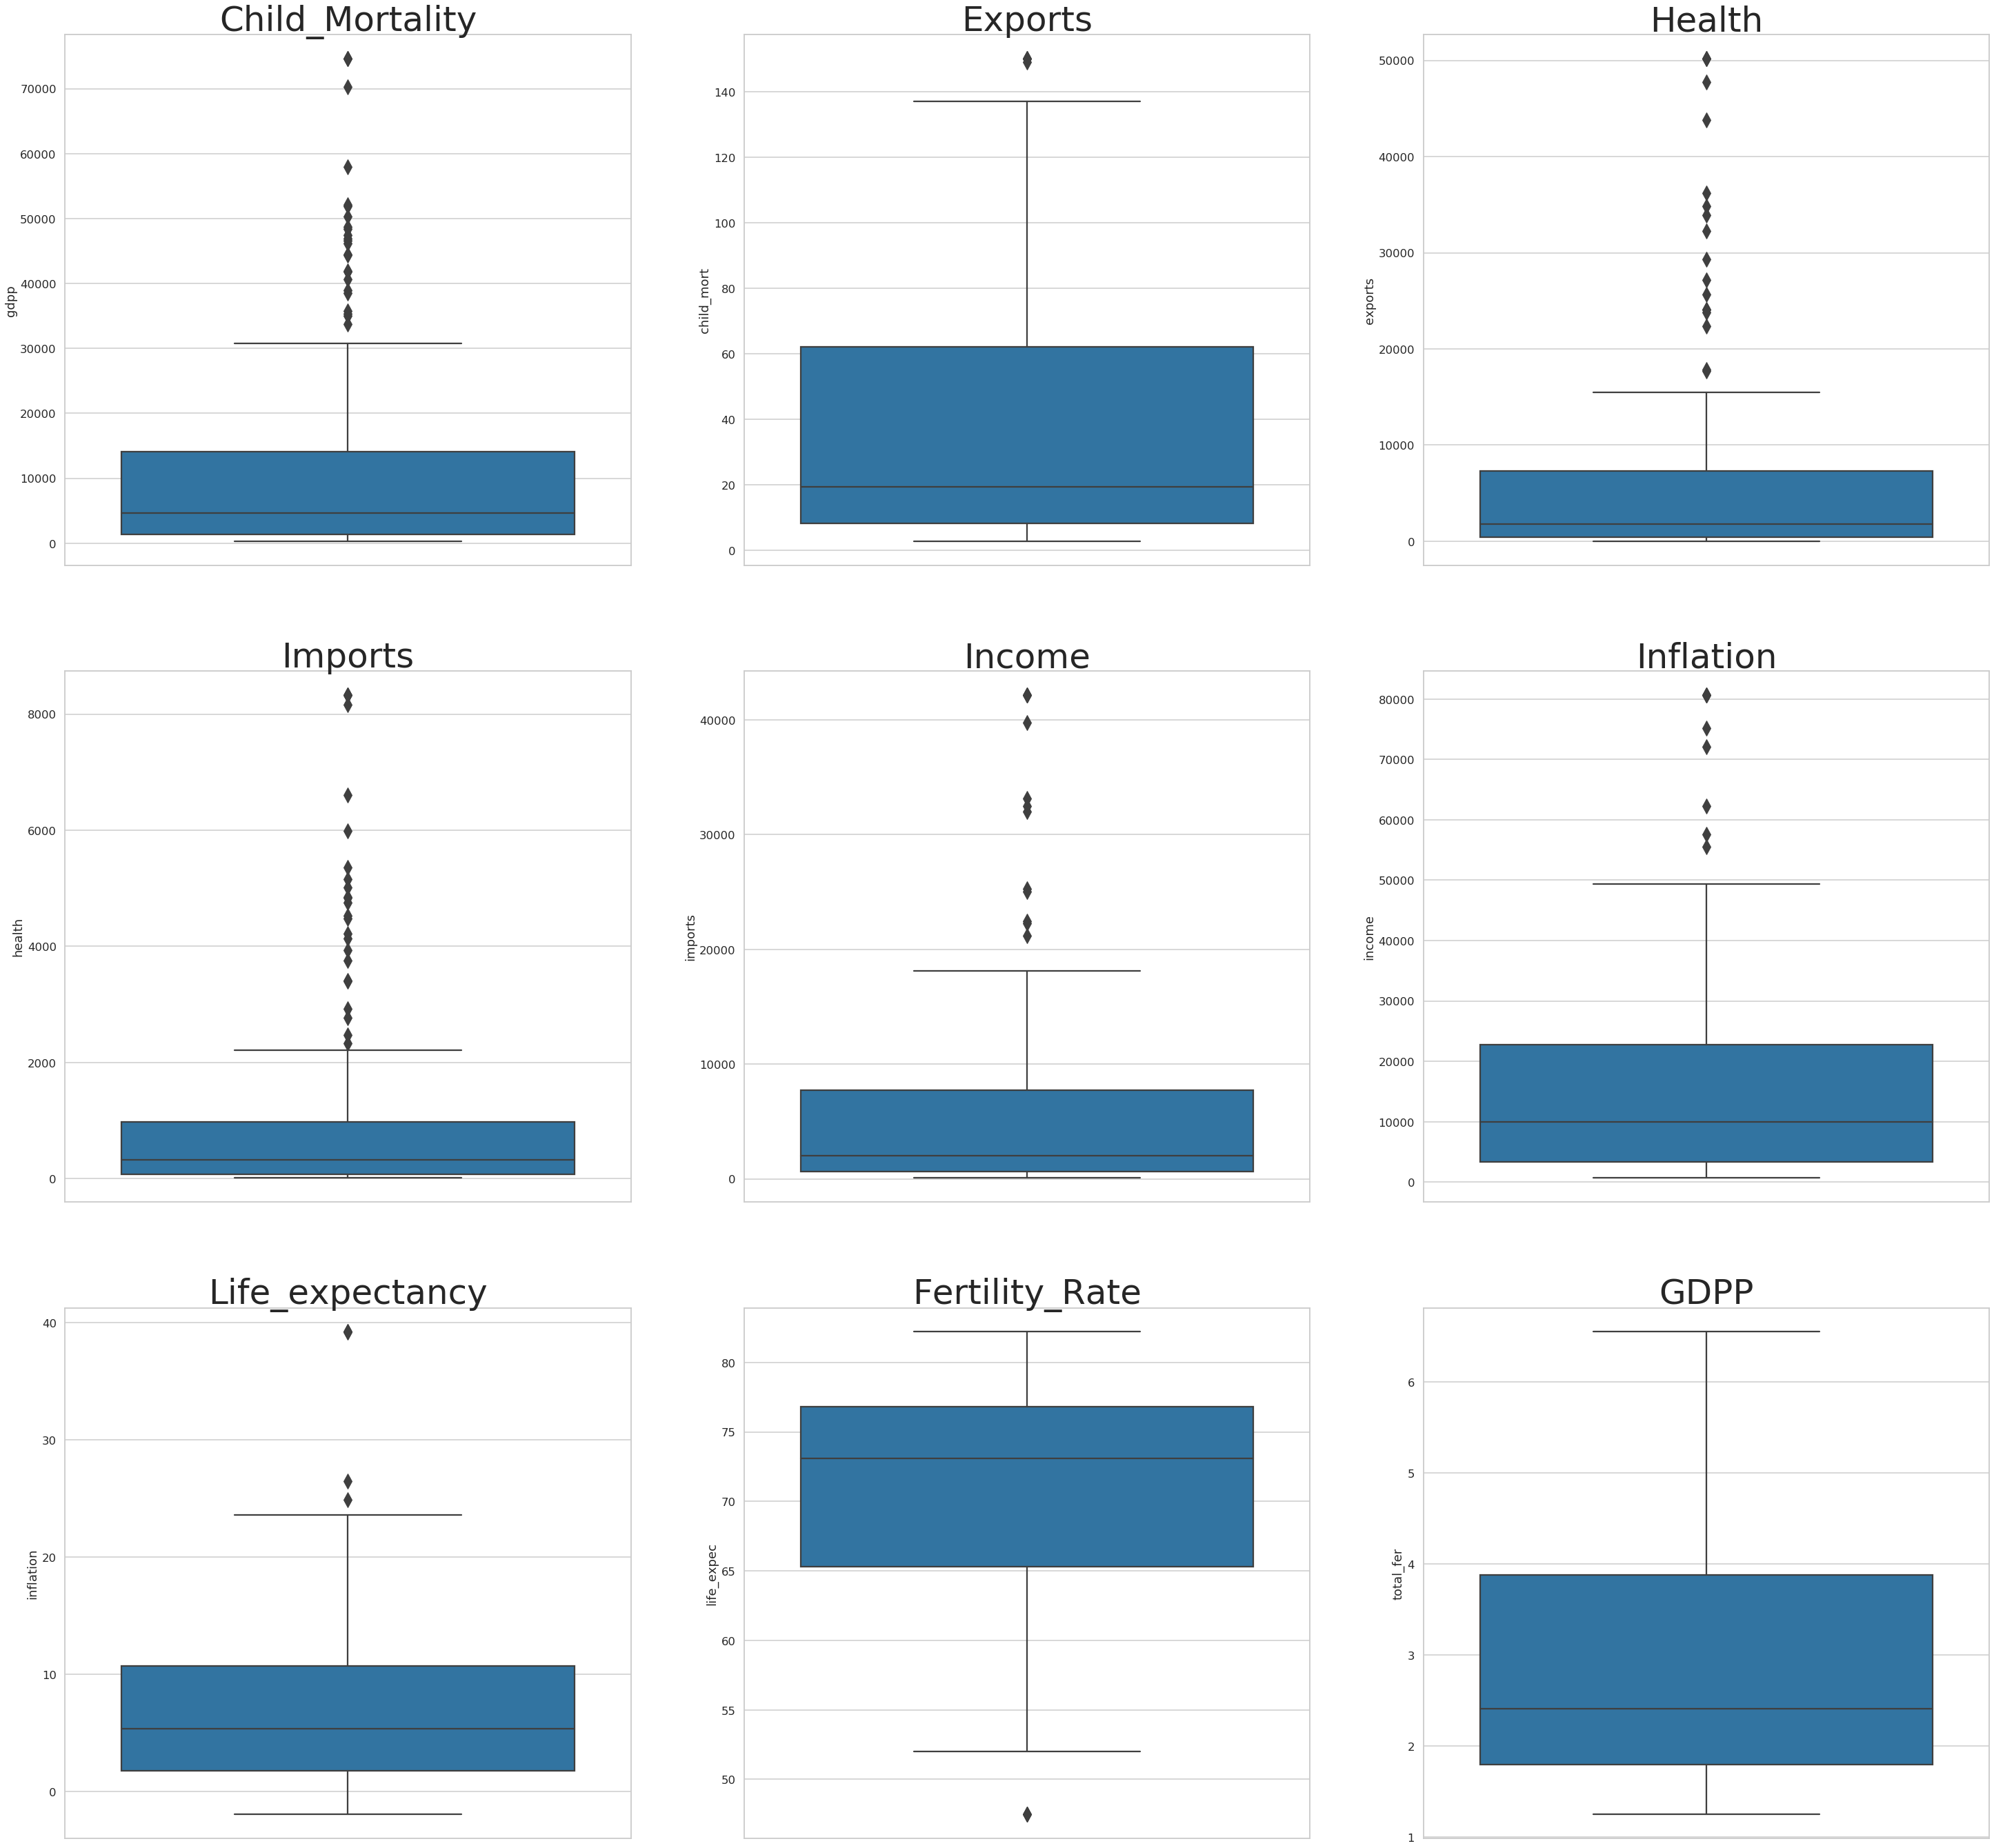

In [18]:
### Performing outlier analysis using boxplots

plt.figure(figsize=(50,150))
plt.tight_layout()
sns.set_style('whitegrid')
sns.set_context('talk')

# Title names for the columns in the dataset

columnNames={0:'Child_Mortality',1:'Exports',2:'Health',3:'Imports',4:'Income',5:'Inflation',
     6:'Life_expectancy',7:'Fertility_Rate',8:'GDPP'}

# Visualising the outliers with boxplot for all the variables 

for i in range(9):
    plt.subplot(9,3,i+1)
    plt.title(columnNames[i],fontsize=50)
    sns.boxplot(x=countriesDatasetWithoutOutliers.columns[i-1],data=countriesDatasetWithoutOutliers,orient='v',fliersize=15)

<Figure size 1800x1800 with 0 Axes>

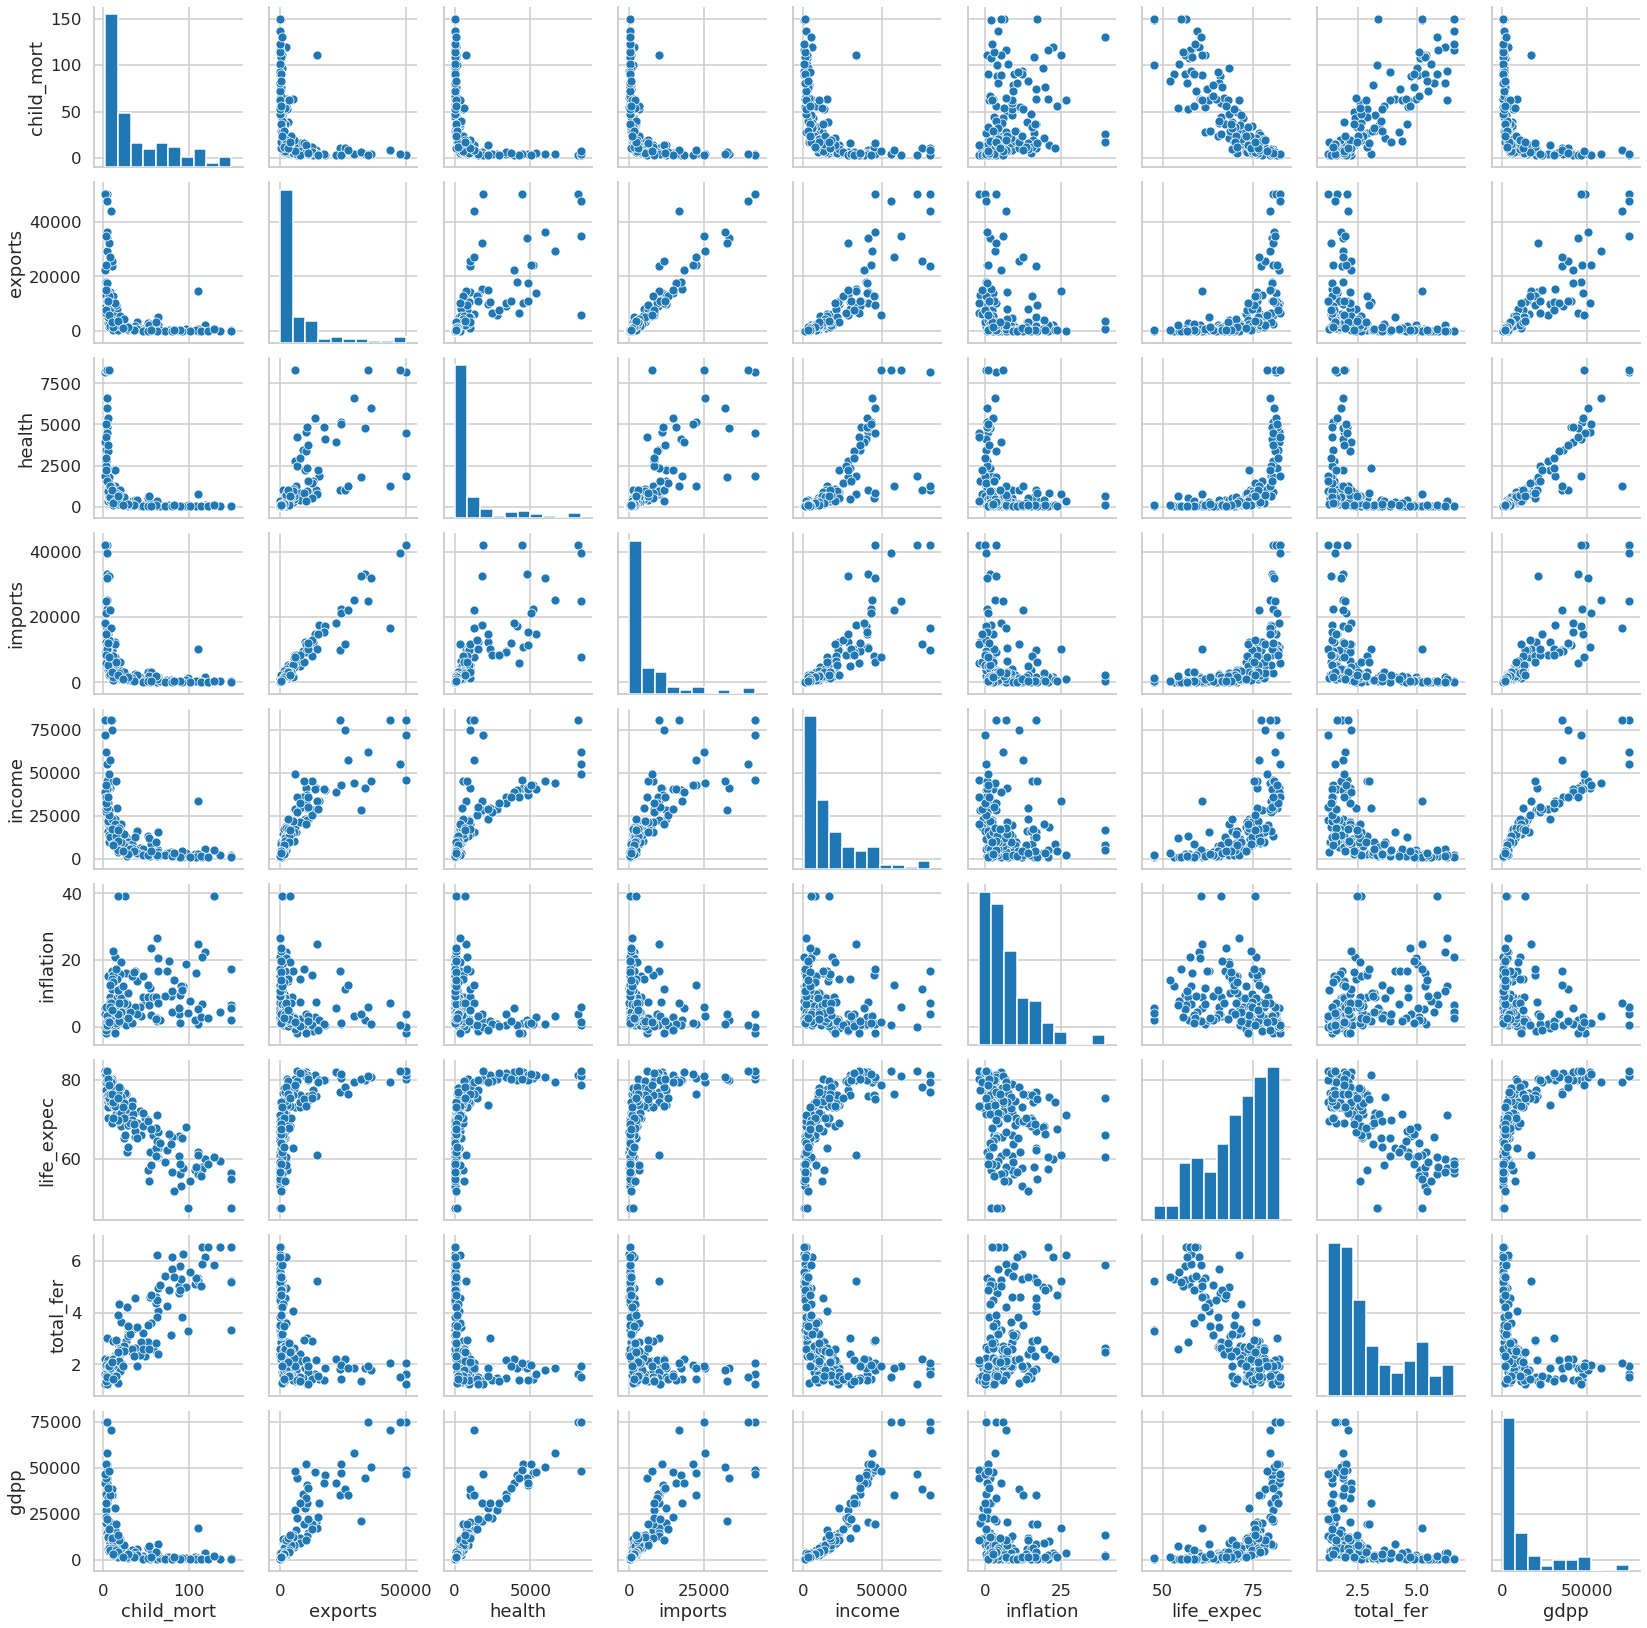

In [19]:
### Let us also plot a pairplot for the same after removing outliers
plt.figure(figsize = (25,25))
sns.pairplot(countriesDatasetWithoutOutliers)
plt.show()

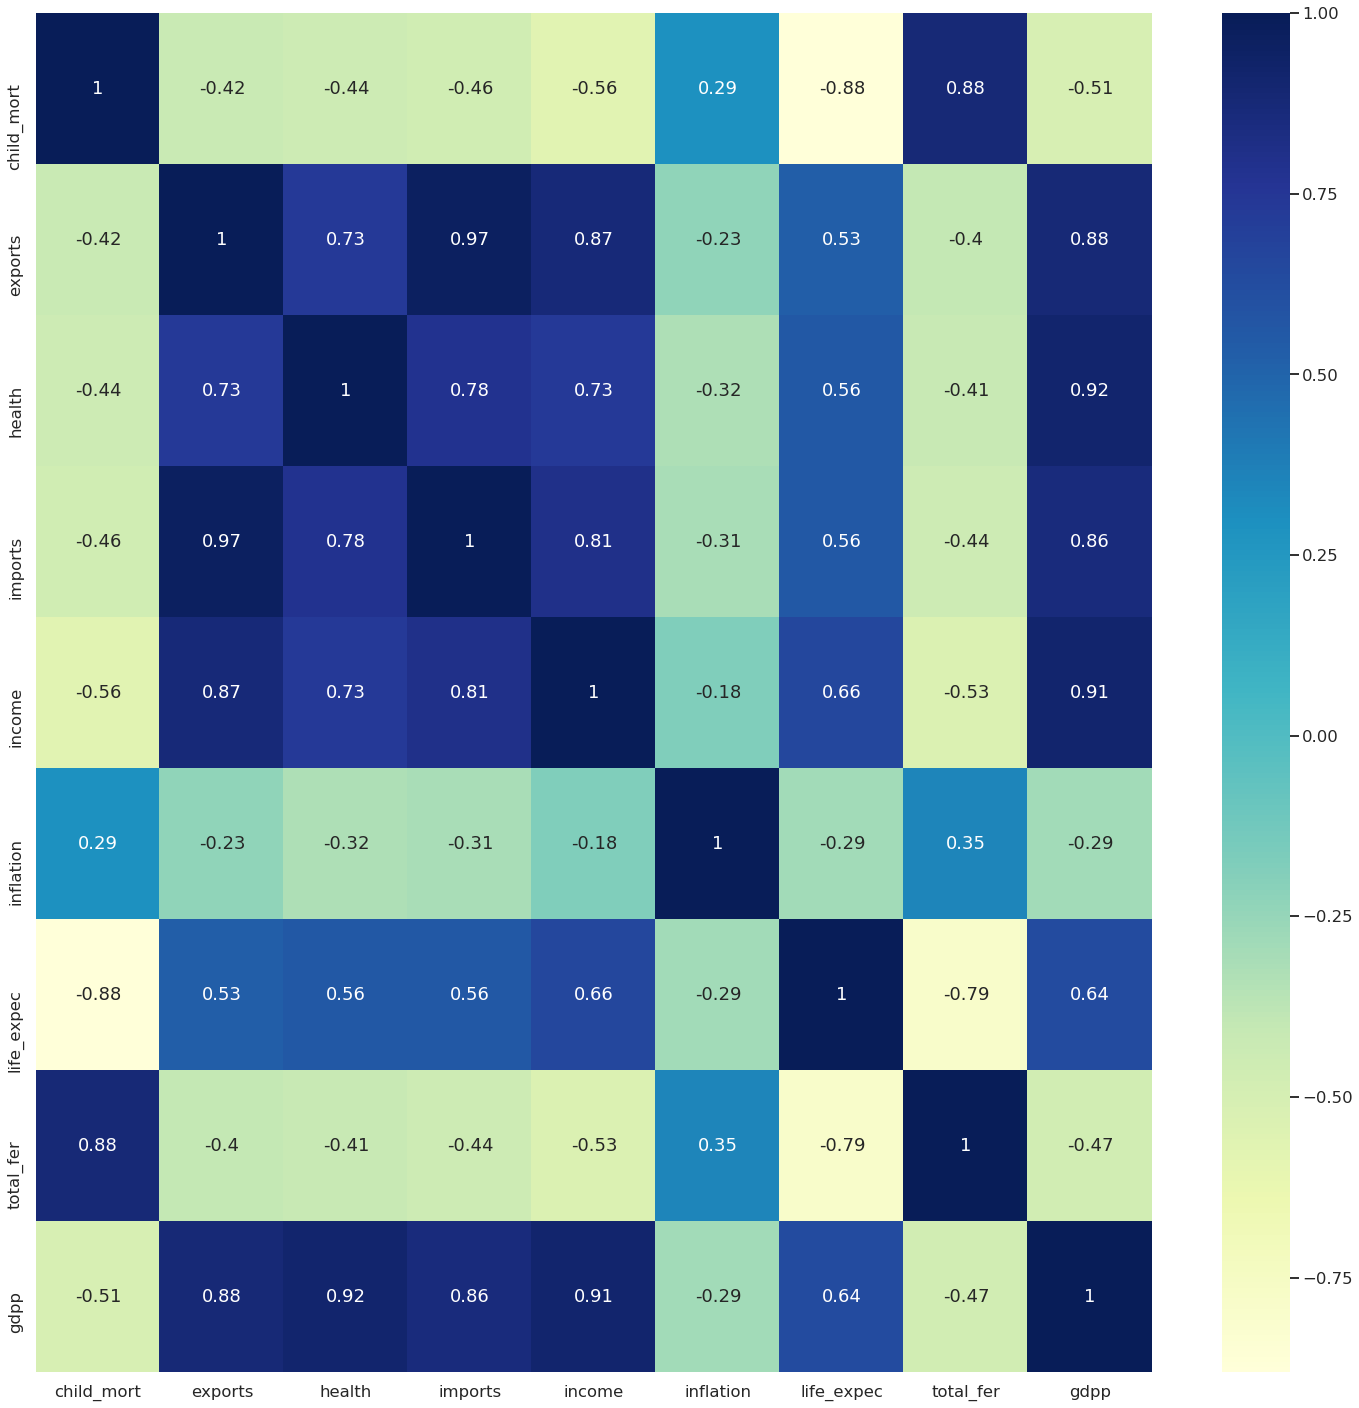

In [20]:
### Let us plot a heatmap to understand the correlation 
### between the data after removing the outliers
plt.figure(figsize = (25,25))  
sns.heatmap(countriesDatasetWithoutOutliers.corr(),annot = True,cmap="YlGnBu")

### Observation:

After treating for outliers and dropping values above 99% & below 1% we observe that the max value for the columns 'child_mort', 'inflation', 'income', 'gdpp', 'exports' and 'imports' has changed to lower values than in the original dataset. For reference the max value of in th 'child_mort' column has now become 150.000607, which is lower than the previous 208. This is the same for all the columns with outliers. 

A significant change can be seen in the distplot in the 'life_expec' graph where outlier treatment has resulted in the value close to 30 being treated and the graph has a lower limit close to 50 instead of 30. Similarly in the gdpp column, the higher value has been treated to be closer to 80000.

We also observe that after the outlier treatment there is a change in correlation values, as represented by the heatmaps, between various variables. For example, there is an increase in the correlation between imports & gdpp, exports & gdpp. Health & exports also have a higher correlation value, just to highlight a few. 


We will now perform Hopkins analysis to identify how well the data clusters. The  Hopkins score is calculated between 0-1. A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0

In [21]:
### Let us define a function for Hopkins analysis.

def hopkinsAnalysis(inputDataframe):
    rows = len(inputDataframe)
    cols = inputDataframe.shape[1]
    val = int(0.1 * rows) 
    nearestNeighbors = NearestNeighbors(n_neighbors=1).fit(inputDataframe.values)
 
    rand_inputDataframe = sample(range(0, rows, 1), val)
 
    ujd = []
    wjd = []
    for j in range(0, val):
        u_dist, _ = nearestNeighbors.kneighbors(uniform(np.amin(inputDataframe,axis=0),np.amax(inputDataframe,axis=0),cols).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nearestNeighbors.kneighbors(inputDataframe.iloc[rand_inputDataframe[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return round(H, 3)

In [22]:
print("Hopkins Score for data without outliers: ", hopkinsAnalysis(countriesDatasetWithoutOutliers))
print("Hopkins Score for data with outliers: ", hopkinsAnalysis(countriesDataset))

Hopkins Score for data without outliers:  0.935
Hopkins Score for data with outliers:  0.912


### Observation:

From the Hopkins scores we can see that the data has a very high clustering tendency. 

In [23]:
### Scaling the data. We will be using the original datafame for scaling
standardScaler = StandardScaler()

countriesDatasetScaled = standardScaler.fit_transform(countriesDatasetWithoutOutliers)
countriesDatasetScaled = pd.DataFrame(countriesDatasetScaled, columns=countriesDataset.columns)

countriesDatasetScaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.349194,-0.596982,-0.567764,-0.632881,-0.857246,0.270796,-1.696807,1.927611,-0.707341
1,-0.548177,-0.493833,-0.440894,-0.431518,-0.388130,-0.378462,0.663898,-0.866139,-0.501439
2,-0.272337,-0.440129,-0.486882,-0.499506,-0.220669,1.144342,0.687387,-0.035384,-0.479900
3,2.091644,-0.394082,-0.534815,-0.486317,-0.615358,1.970670,-1.238760,2.155399,-0.534039
4,-0.710588,-0.076862,-0.178280,0.170226,0.128913,-0.778509,0.722622,-0.544556,-0.029325


#### Note: 
We are scaling the data because we are dealing with features that have different scales. If a feature has a higher scale value than another, then it will skew the model heavily towards itself and ignore the feautres that have signinificantly lower scales. 

Scaling helps bring all the features on a common scale so that the values are treated equally. 

### Silhouette & Elbow Analysis

Before we cluster our data let us first perform these to analyses as well. This will give us a firm idea on how many clusters we should choose. 


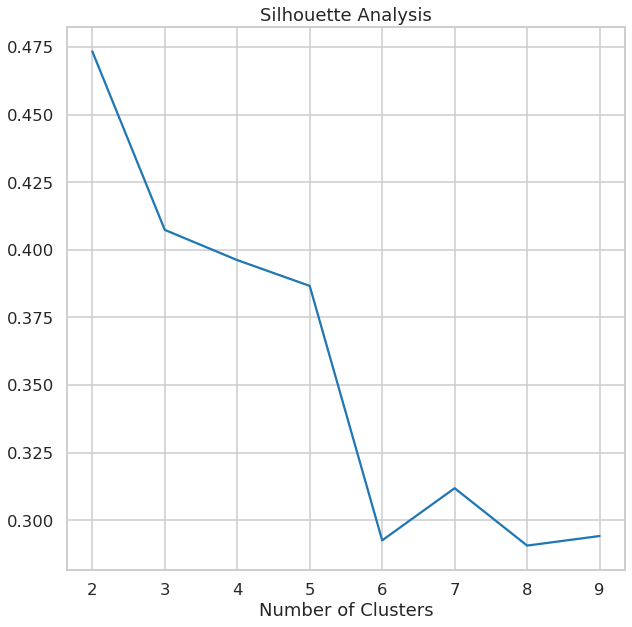

In [24]:
#First we'll do the silhouette analysis
silhoutteScore = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(countriesDatasetScaled)
    silhoutteScore.append([k, silhouette_score(countriesDatasetScaled, kmeans.labels_)])

plt.figure(figsize = (10,10))
plt.xlabel('Number of Clusters')
plt.title('Silhouette Analysis')
plt.plot(pd.DataFrame(silhoutteScore)[0], pd.DataFrame(silhoutteScore)[1]);


### Observation
Based on the Silhoutte analysis above we can see that there is a significant drop around 3. So 3 seems like a good value for clustering right now. 

Let us confirm this with Elbow analysis as well. 

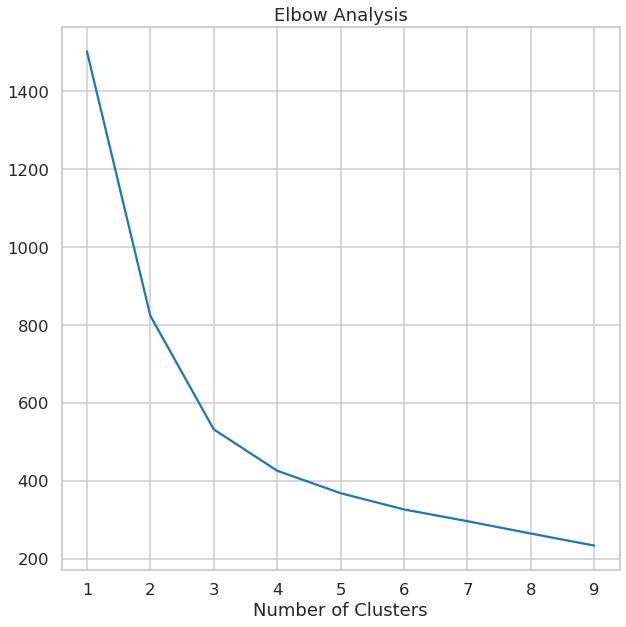

In [25]:
# We will now do elbow curve analysis
elbowScore = []
for k in list(range(1,10)):
    model = KMeans(n_clusters = k, max_iter = 50).fit(countriesDatasetScaled)
    elbowScore.append([k, model.inertia_])

plt.figure(figsize = (10,10))
plt.xlabel('Number of Clusters')
plt.title('Elbow Analysis')

plt.plot(pd.DataFrame(elbowScore)[0], pd.DataFrame(elbowScore)[1]);

### Observation
From the elbow analysis as well we can see that 3 seems like a good cluster value. 

### Note:

From both silhoutte and elbow analysis we see that 2 is a better cluster value, however taking 2 clusters is not recommended because it might mask certain intricacies in the data and therefore produce inconsistent result. This might lead to incorrect classification of countries. This is also a binary classification of data.

Our data is now fully prepared to perform K-means and Heirarchial clustering.

# 3. K-Means Clustering & Visulaization

In [26]:
#Let's perform K means using K=3
clusteredCountriesDataset = KMeans(n_clusters = 3, max_iter = 50, random_state = 50)
clusteredCountriesDataset.fit(countriesDatasetScaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [27]:
### Assessing the labels generated
clusteredCountriesDataset.labels_


array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2], dtype=int32)

In [28]:
### Assigning the new labels generated by the clusters to a column in the dataframe

countriesDatasetWithClusterLabels = countriesDatasetWithoutOutliers
countriesDatasetWithClusterLabels['cluster_id']= clusteredCountriesDataset.labels_

In [29]:
countriesDatasetWithClusterLabels.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
country,,,,,,,,,,
Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [30]:
countriesDatasetWithClusterLabels.shape

(167, 10)

In [31]:
countriesDatasetWithClusterLabels.isnull().sum()

child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    0
dtype: int64

In [32]:
countriesDatasetWithClusterLabels.cluster_id.value_counts()

0    90
2    48
1    29
Name: cluster_id, dtype: int64

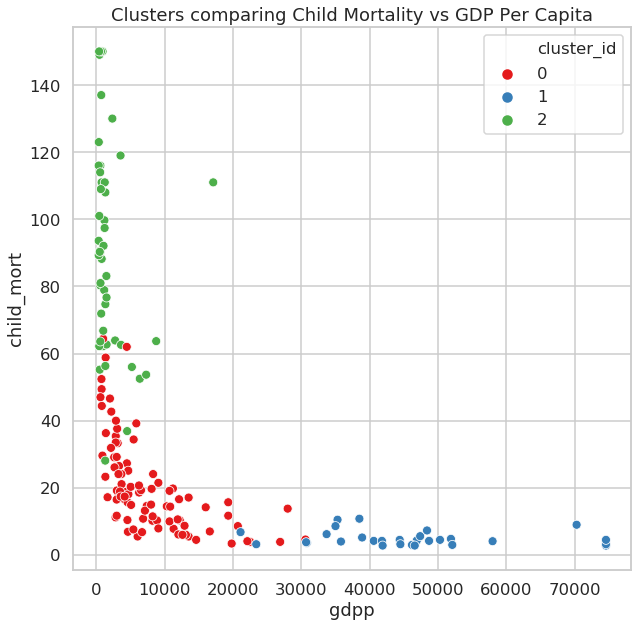

In [33]:
plt.figure(figsize = (10,10))
plt.title("Clusters comparing Child Mortality vs GDP Per Capita")

sns.scatterplot(x = 'gdpp', y = 'child_mort', hue ='cluster_id', legend = 'full', data = countriesDatasetWithClusterLabels, palette='Set1')

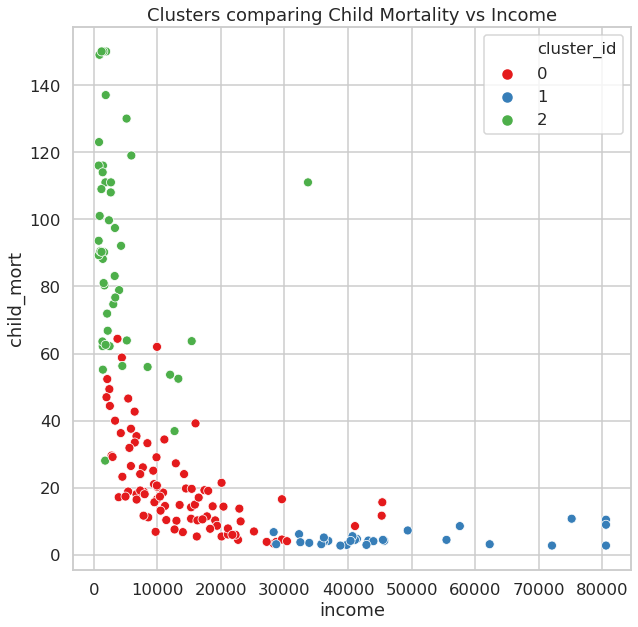

In [34]:
plt.figure(figsize = (10,10))
plt.title("Clusters comparing Child Mortality vs Income")
sns.scatterplot(x = 'income', y = 'child_mort', hue ='cluster_id', legend = 'full', data = countriesDatasetWithClusterLabels, palette='Set1')

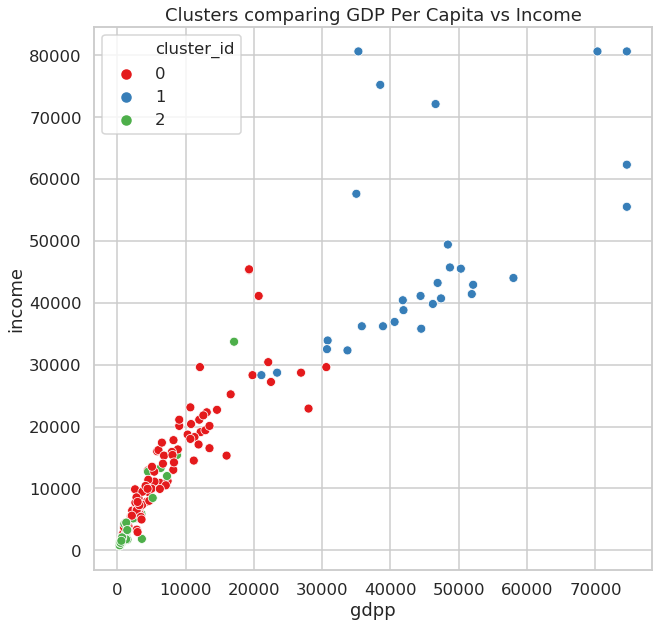

In [35]:
plt.figure(figsize = (10,10))
plt.title("Clusters comparing GDP Per Capita vs Income")
sns.scatterplot(x = 'gdpp', y = 'income', hue ='cluster_id', legend = 'full', data = countriesDatasetWithClusterLabels, palette='Set1')

### Observations

Based on the 3 scatter plots above we can see that:

- Cluster 2 contains countries with low income and gdpp but a very high child mortality rate
- Cluster 1 has countries with the highest income and gdpp but a vert low child mortality rate
- We should primarily focus on countries in cluster 2 which can identify countries in dire need
- Some countries in cluster 0 might also need help but our primary concern should focus on cluster 2 countries

### Profiling

<Figure size 2160x2160 with 0 Axes>

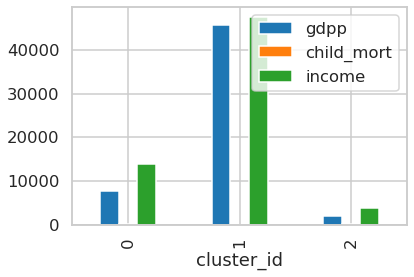

In [36]:
plt.figure(figsize = (30,30))
countriesDatasetWithClusterLabels.groupby('cluster_id')[['gdpp', 'child_mort', 'income']].mean().plot(kind = 'bar')

<Figure size 2160x2160 with 0 Axes>

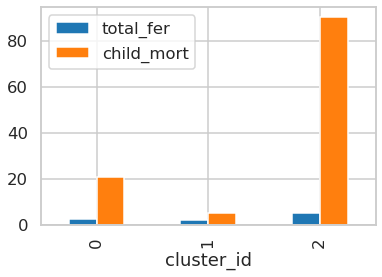

In [37]:
plt.figure(figsize = (30,30))
countriesDatasetWithClusterLabels.groupby('cluster_id')[['total_fer', 'child_mort']].mean().plot(kind = 'bar')

### Observation

From the profiling we can see that cluster 2 has the lowest values for gdpp & income. 
We also observe that cluster 2 has the highest child_mortality rate and the highest total_fertility of all the countries.

In [38]:
countriesDatasetWithClusterLabels[countriesDatasetWithClusterLabels['cluster_id']==2].sort_values(by=[ 'gdpp', 'child_mort', 'income'], ascending=[False,True,True]) 

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
country,,,,,,,,,,
Equatorial Guinea,111.000000,14671.800000,766.0800,10071.900000,33700.000000,24.90,60.9,5.210000,17100.000000,2
Gabon,63.700000,5048.750000,306.2500,1653.750000,15400.000000,16.60,62.9,4.080000,8750.000000,2
South Africa,53.700000,2082.080000,650.8320,1994.720000,12000.000000,6.35,54.3,2.590000,7280.000000,2
Botswana,52.500000,2768.600000,527.0500,3257.550000,13300.000000,8.92,57.1,2.880000,6350.000000,2
Namibia,56.000000,2480.820000,351.8820,3150.330000,8460.000000,3.56,58.6,3.600000,5190.000000,2
...,...,...,...,...,...,...,...,...,...,...
Sierra Leone,150.000607,67.032000,52.2690,137.655000,1220.000000,17.20,55.0,5.200000,399.000000,2
Niger,123.000000,77.256000,17.9568,170.868000,814.000000,2.55,58.8,6.550002,348.000000,2
"Congo, Dem. Rep.",116.000000,137.274000,26.4194,165.664000,763.996114,20.80,57.5,6.540000,334.000000,2


### Observations

From the above profiling and analysis we can conclude that HELP International should focus on the 5 countries mentioned at the bottom of the table. These are: Burindi, Liberia, Congo, Dem. Rep., Niger & Sierra Leone.

These countries have the highest child mortality rates, lowest incomes and lowest gdpp. 

We will now perform Hierarchial clustering to see if these results are observed again. 

# 4. Heirarchial Clustering


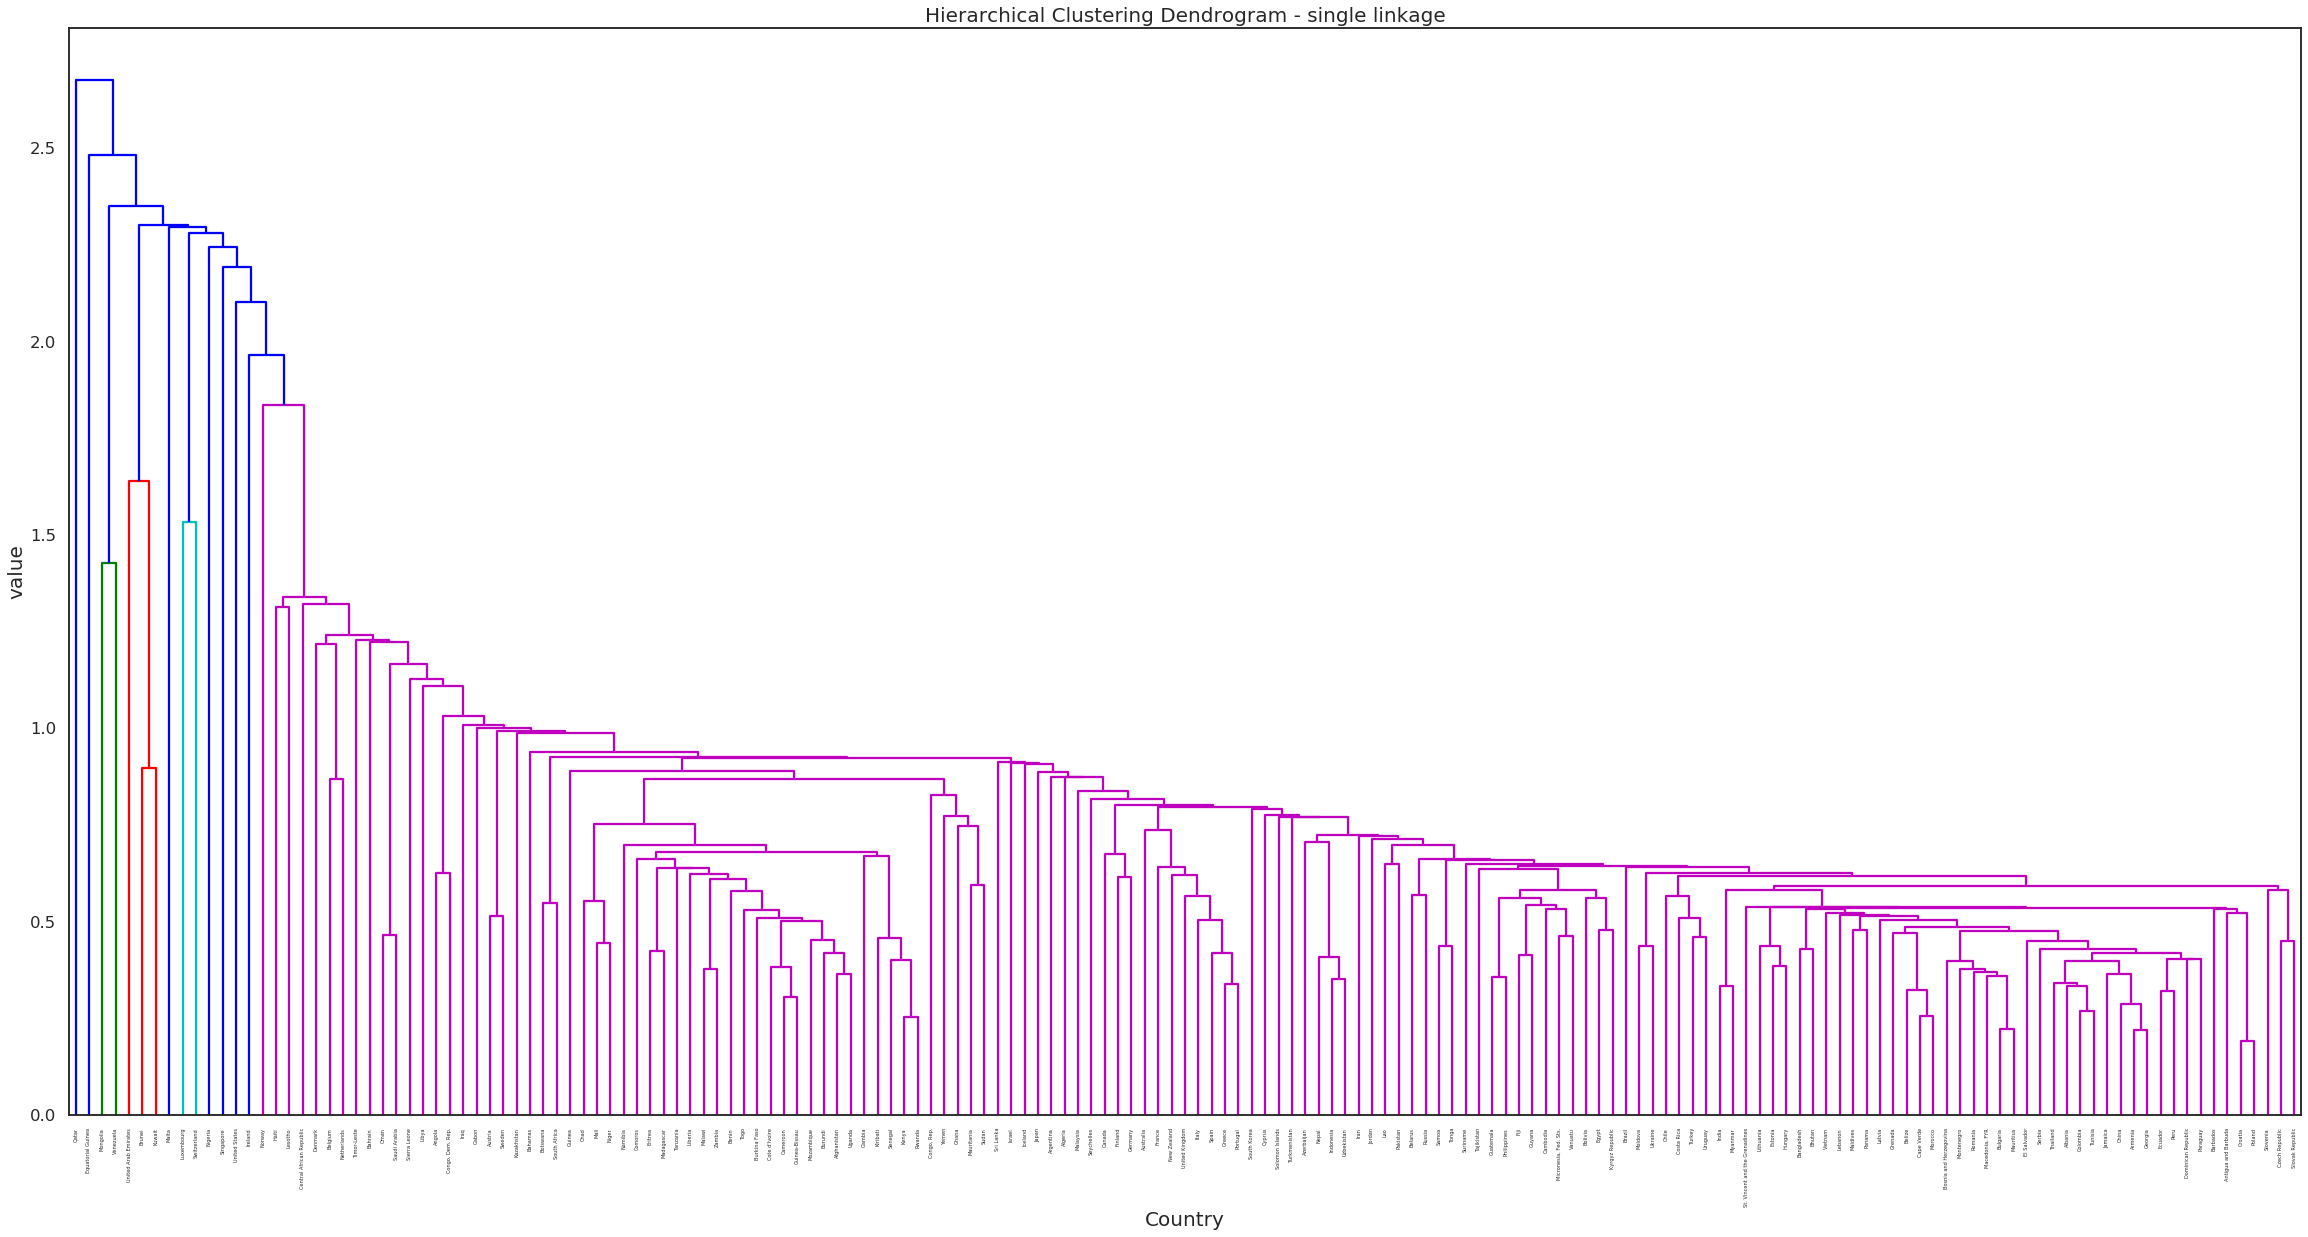

In [39]:
### Let us perform Heirarchial Clustering on scaled data
### First we will perform single linkage clustering. 

plt.figure(figsize=(40,20))
sns.set_style('white')

labs= countriesDataset.index # labels 

# setting the labels on axes and title

plt.title('Hierarchical Clustering Dendrogram - single linkage',fontsize=20)
plt.xlabel('Country',fontsize=20)
plt.ylabel('value',fontsize=20)
singleLinkage=linkage(countriesDatasetScaled,method='single',metric='euclidean')  
dendrogram(singleLinkage,labels=labs)                     
plt.show()     

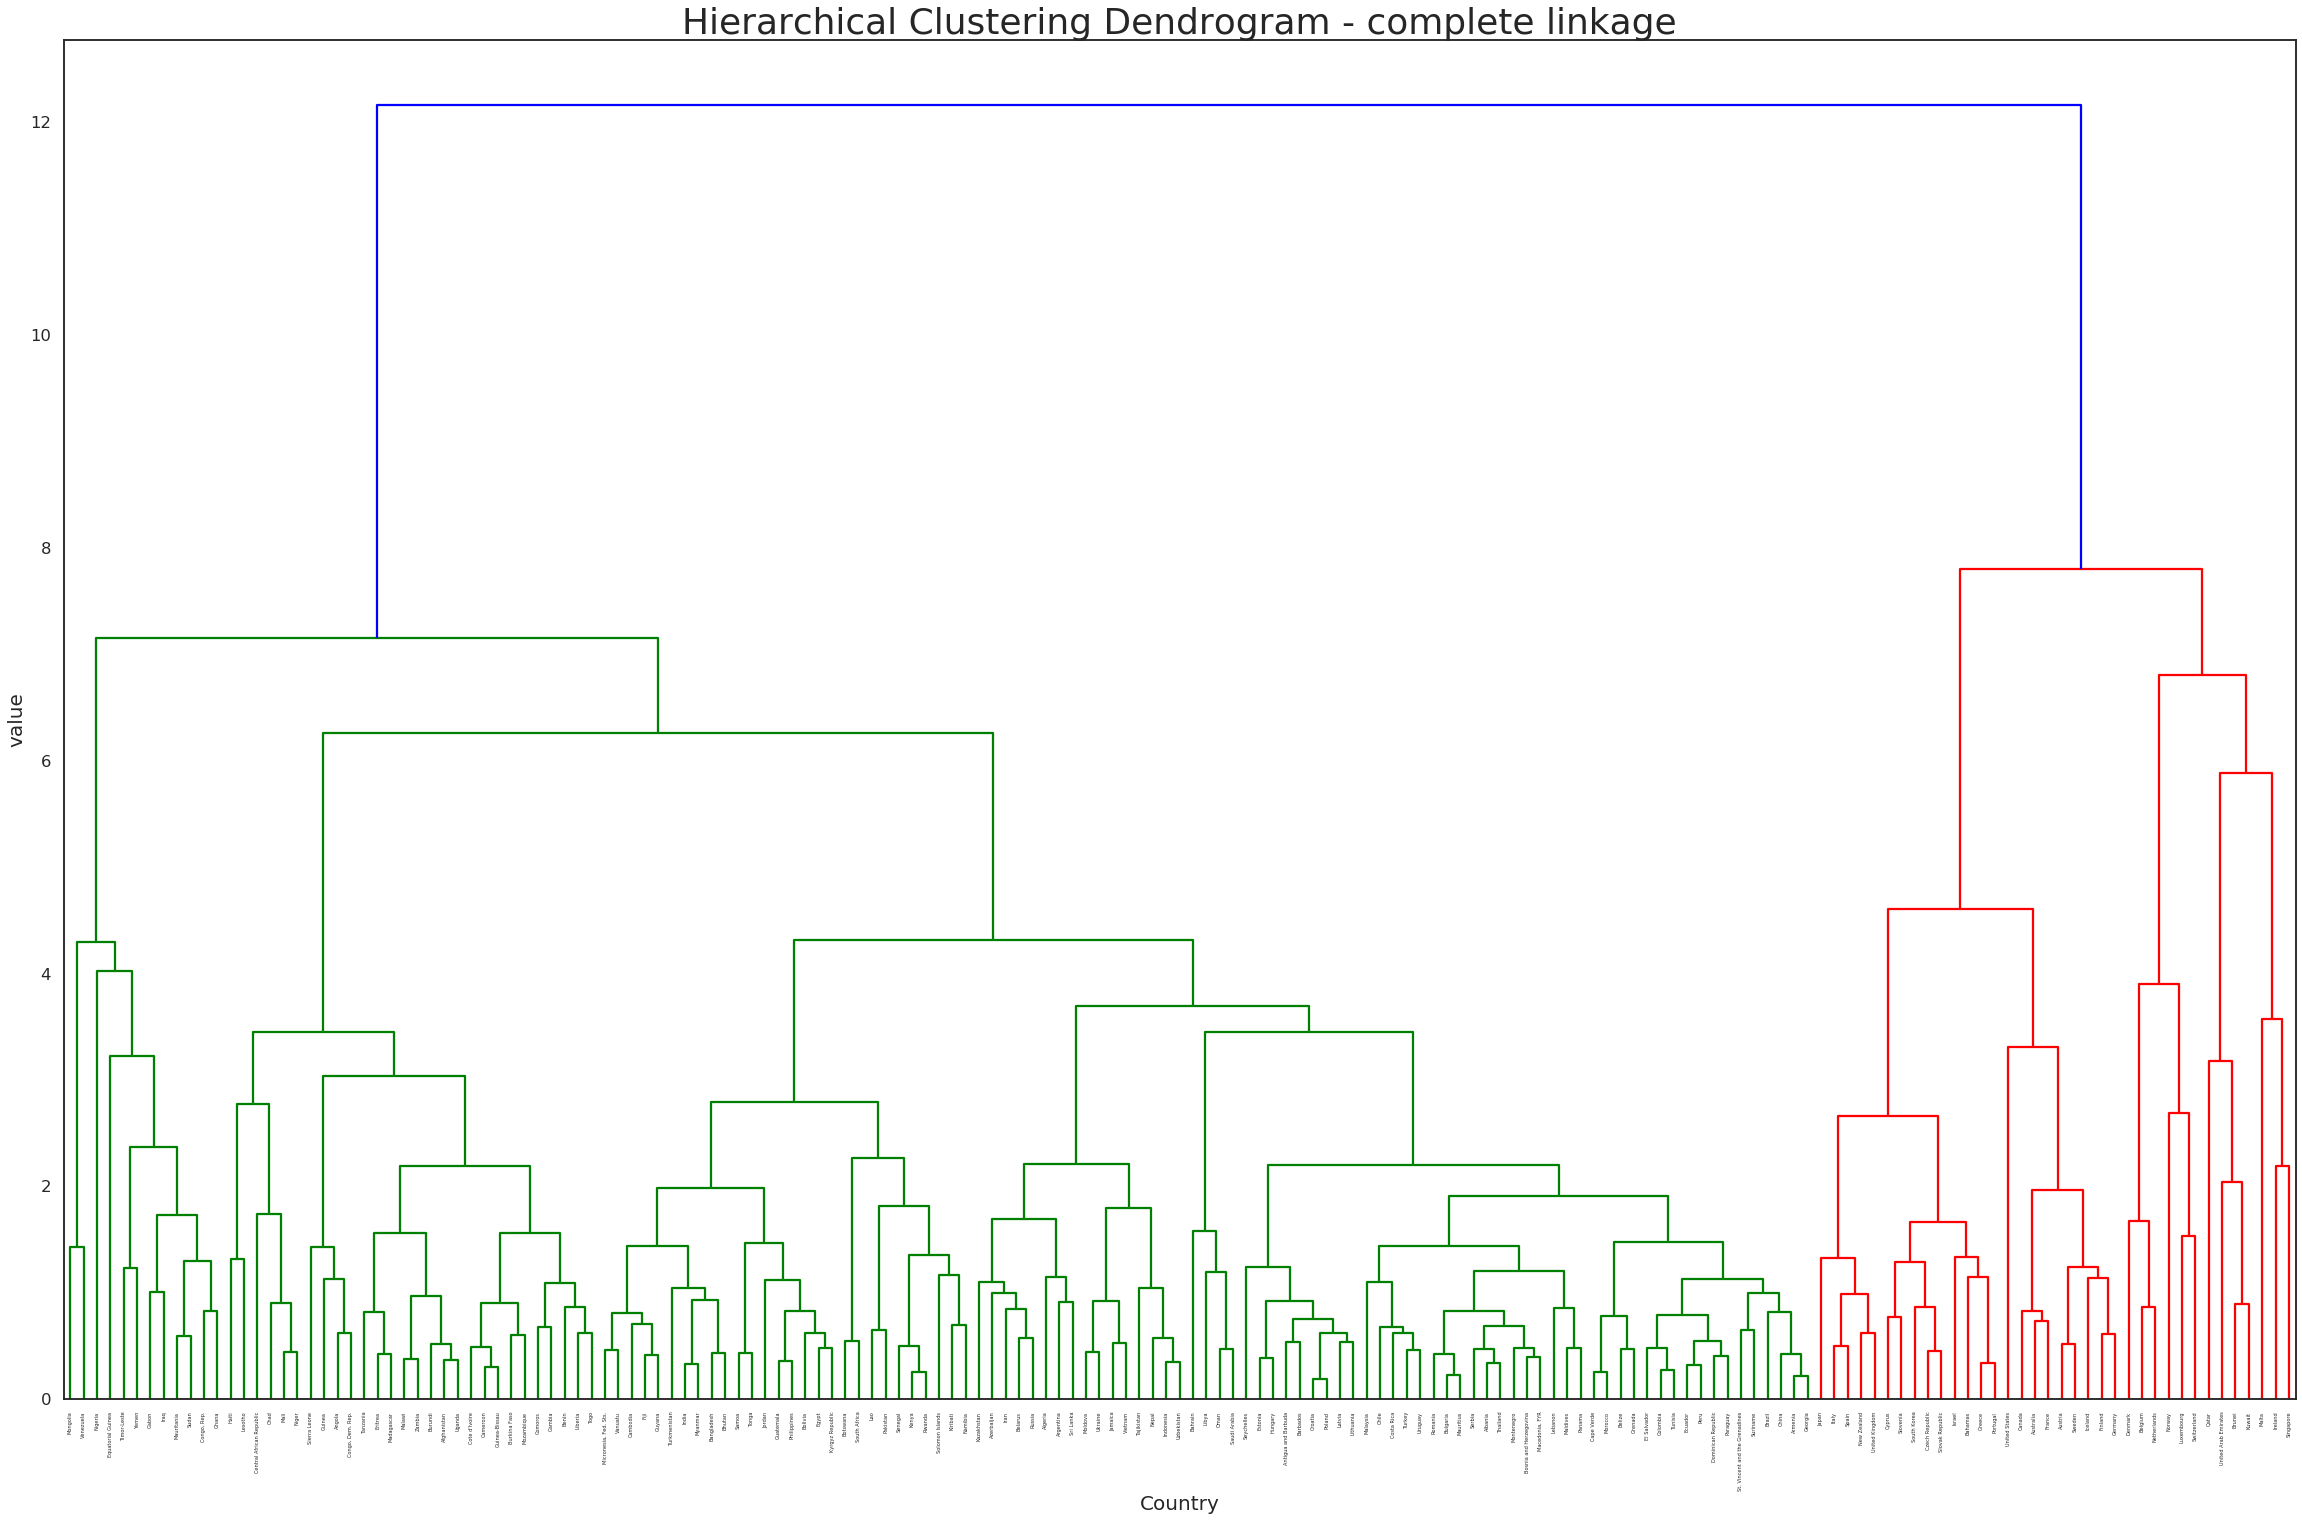

In [40]:
### Let us now perform complete linkage

# Complete linkage

plt.figure(figsize=(40, 25))
sns.set_style('white')

labs= countriesDataset.index ## labels

plt.title('Hierarchical Clustering Dendrogram - complete linkage',fontsize=36)
plt.xlabel('Country',fontsize=20)
plt.ylabel('value',fontsize=20)

completeLinkage=linkage(countriesDatasetScaled,method='complete',metric='euclidean')
dendrogram(completeLinkage,labels=labs) 

plt.show()

### Observations

From the above heirarchial clustering above we can see that single-linkage is yielding us results that are highly varied. We see that through complete linkage we are getting better cluster formations. We will proceed with complete linkage. 

### Cluster Formation

In [41]:
### We will now take a cluster from the completeLinkage cluster, using 2 clusters as observed in the dendogram
cutTree = cut_tree(completeLinkage, n_clusters=2).reshape(-1,)
cutTree

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [42]:
### assigning cluster labels
countriesDatasetWithClusterLabels['cluster_labels_linkage'] = cutTree
countriesDatasetWithClusterLabels.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels_linkage
country,,,,,,,,,,,
Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,0
Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,0
Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,0


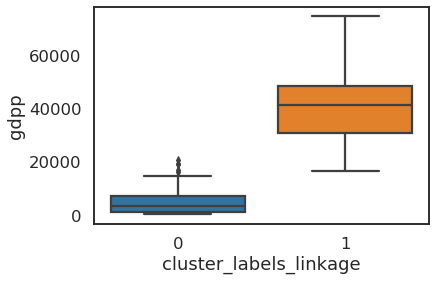

In [43]:
### Let us do a box plot to see the data now
sns.boxplot(x='cluster_labels_linkage', y='gdpp', data=countriesDatasetWithClusterLabels)

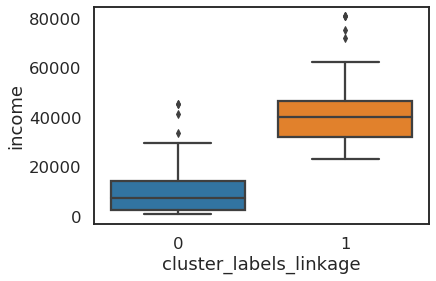

In [44]:
sns.boxplot(x='cluster_labels_linkage', y='income', data=countriesDatasetWithClusterLabels)

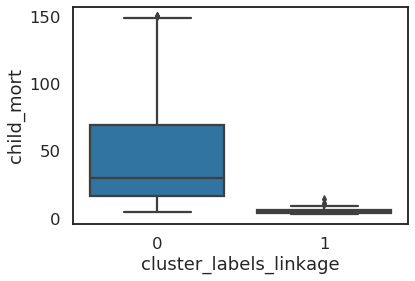

In [45]:
sns.boxplot(x='cluster_labels_linkage', y='child_mort', data=countriesDatasetWithClusterLabels)

### Observation

From the clusters above we can see that cluster 0 has the lowest income & gdpp but the highest child mortality. 
This behaviour is similar to cluster 2 from K-means. 


We will focus on cluster 0 for further analysis. 

<Figure size 2160x2160 with 0 Axes>

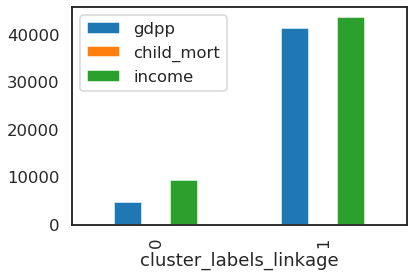

In [46]:
## Profiling

plt.figure(figsize = (30,30))
countriesDatasetWithClusterLabels.groupby('cluster_labels_linkage')[['gdpp', 'child_mort', 'income']].mean().plot(kind = 'bar')

<Figure size 2160x2160 with 0 Axes>

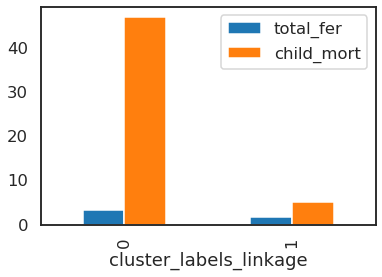

In [47]:
plt.figure(figsize = (30,30))

countriesDatasetWithClusterLabels.groupby('cluster_labels_linkage')[['total_fer', 'child_mort']].mean().plot(kind = 'bar')

### Observation

From the plots above we can see similar behaviour in cluster 0 as we did with cluster 2 with K-means. 

The income and gdpp values are lower in cluster 0 while the child moratlity and fertility rates are higher. 


In [48]:
countriesDatasetWithClusterLabels[countriesDatasetWithClusterLabels['cluster_labels_linkage']==0].sort_values(by=[ 'gdpp', 'child_mort', 'income'], ascending=[False,True,True]) 

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels_linkage
country,,,,,,,,,,,
Bahrain,8.600000,14386.500000,1028.7900,10536.300000,41100.000000,7.440,76.0,2.160000,20700.000000,0,0
Oman,11.700000,12680.100000,534.6100,7951.600000,45300.000000,15.600,76.1,2.900000,19300.000000,0,0
Saudi Arabia,15.700000,9572.800000,827.9700,6369.000000,45400.000000,17.200,75.1,2.960000,19300.000000,0,0
Equatorial Guinea,111.000000,14671.800000,766.0800,10071.900000,33700.000000,24.900,60.9,5.210000,17100.000000,2,0
Barbados,14.200000,6320.000000,1275.2000,7792.000000,15300.000000,0.321,76.7,1.780000,16000.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
Sierra Leone,150.000607,67.032000,52.2690,137.655000,1220.000000,17.200,55.0,5.200000,399.000000,2,0
Niger,123.000000,77.256000,17.9568,170.868000,814.000000,2.550,58.8,6.550002,348.000000,2,0
"Congo, Dem. Rep.",116.000000,137.274000,26.4194,165.664000,763.996114,20.800,57.5,6.540000,334.000000,2,0


### Observation

From the above profiling and analysis we can conclude that HELP International should focus on the 5 countries mentioned at the bottom of the table. As we saw with K-Means clustering, these are: Burindi, Liberia, Congo, Dem. Rep., Niger & Sierra Leone.

These countries have the highest child mortality rates, lowest incomes and lowest gdpp.

The results we have obtained are consistent in both our clustering methods. We can conclusively say that the countries we have identified are in need of dire aid. 

# Conclusion

The HELP International NGO should focus on the 5 countries outlined below for immediate aid:

- Burindi
- Liberia 
- Congo, Dem. Rep.
- Niger	
- Sierra Leone

From the analysis we have carried out from the provided countries data we can conclusively say that based on the following factors:

- The countries in cluster 2(K-Means) & cluster 0(Hierarchial) have the lowest GDP Per Capita(GDPP)
- These countries have the lowest income as well as the highest child_mortality rate
- The fertility rate for these countries is very high but due to low incomes the child mortality rate is also high, which leads to the assumption that the children are born but are unable to be fed due to low family incomes.

# End Of File